## Results

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from typing import Dict
import pandas as pd
from tqdm import tqdm

def read_json(path: str) -> Dict:
    with open(path) as file:
        return json.load(file)

matplotlib.rc('text', usetex = True)

In [2]:
def get_stats(
        sources,
        rows,
        columns=['Adam', 'Adagrad', 'SGD'],
        extraction_function = lambda a: a['acc/val'][-1],
        highlight_max=True,
        precision=3,
        file_extraction_function=None):
    res = []
    maxis = []
    for entries in sources:
        res.append([])
        maxv, maxi = 0, -1
        if not highlight_max:
            maxv = 100000000.0
        for j, entry in tqdm(enumerate(entries)):
            count = 0
            x = []
            for i in range(3):
                path = f'results/{entry}_{i}/stats.json'
                if os.path.exists(path):
                    count += 1
                    if file_extraction_function is not None:
                        x.append(file_extraction_function(path))
                    else:
                        obj = read_json(path)
                        x.append(extraction_function(obj))
            x = np.sort(x)
            v = None
            if len(x) == 0:
                res[-1].append(None)
            elif len(x) == 1:
                res[-1].append(x[0])
                v = x[0]
            elif len(x) == 2:
                print("Warning 2", path)
                res[-1].append(x[0])
                v = x[0]
            else:
                res[-1].append((x[1], max(x[2]-x[1], x[1]-x[0])))
                v = x[1]
            if v is not None and ((v > maxv and highlight_max) or (v < maxv and (not highlight_max))):
                maxv, maxi = v, j
        maxis.append(maxi)
#             res[-1].append(count)
    def transform(x):
        if isinstance(x, tuple):
            return f'{x[0]:.{precision}f} \pm {x[1]:.{precision}f}'
        elif x is None:
            return '-'
        else:
            return f'{x:.{precision}f}'

    def bolder(x, i, j):
        y = transform(x)
        if maxis[i] == j:
            return f'$\\bm{{{y}}}$'
        else:
            return f'${y}$'
    
    df = pd.DataFrame(
        list(zip(*[[bolder(x, i, j) for j, x in enumerate(line)] for i, line in enumerate(res)])),
        index=rows,
        columns=columns
    )
    print(df.to_latex(escape=False))
#     return res

def extract_number_of_critical_points(obj):
    x = np.array(obj["num_iterations/train"])
    ids = np.where(x > 0)[0]
    return ids.shape[0]

In [3]:
from tensorboard.backend.event_processing import event_accumulator

def read_times_from_tensorboard(path):
    path = path.replace("stats.json", "")
    for entry in os.scandir(path):
        if entry.name.startswith("events"):
            ea = event_accumulator.EventAccumulator(entry.path,
               size_guidance={
                   event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                   event_accumulator.IMAGES: 4,
                   event_accumulator.AUDIO: 4,
                   event_accumulator.SCALARS: 0,
                   event_accumulator.HISTOGRAMS: 1,
                })
            ea.Reload()
            try:
                acc = ea.Scalars('acc/val')
                return (acc[-1].wall_time - acc[0].wall_time)/(len(acc)-1)
            except:
                return 0

In [71]:
sources_augment = [
    [
        "ResNet34_CIFAR10_augment_Adam_1",
        "ResNet34_CIFAR10_augment_Adam_0.1",
        "ResNet34_CIFAR10_augment_Adam_0.01",
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.0001",
        "ResNet34_CIFAR10_augment_Adam_0.01_StepLR_0.1_17",
        "ResNet34_CIFAR10_augment_Adam_0.01_CosineAnnealingLR_50_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.001_CosineAnnealingLR_50_0.0001",
        "ResNet34_CIFAR10_augment_Adam_0.01_OneCycleLR_0.1_1_50",
        "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
    ],
    [
        "ResNet34_CIFAR10_augment_Adagrad_1",
        "ResNet34_CIFAR10_augment_Adagrad_0.1",
        "ResNet34_CIFAR10_augment_Adagrad_0.01",
        "ResNet34_CIFAR10_augment_Adagrad_0.001",
        "ResNet34_CIFAR10_augment_Adagrad_0.0001",
        "ResNet34_CIFAR10_augment_Adagrad_0.1_StepLR_0.1_17",
        "ResNet34_CIFAR10_augment_Adagrad_0.1_CosineAnnealingLR_50_0.01",
        "ResNet34_CIFAR10_augment_Adagrad_0.01_CosineAnnealingLR_50_0.001",
        "ResNet34_CIFAR10_augment_Adagrad_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.01",
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_1",
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.01",
        "ResNet34_CIFAR10_augment_SGD_0.001",
        "ResNet34_CIFAR10_augment_SGD_0.0001",
        "ResNet34_CIFAR10_augment_SGD_1_StepLR_0.1_17",
        "ResNet34_CIFAR10_augment_SGD_1_CosineAnnealingLR_50_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.1_CosineAnnealingLR_50_0.01",
        "ResNet34_CIFAR10_augment_SGD_1_OneCycleLR_False_10_1_50",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
    ]
]
rows = [
    'Const. $\eta = 1$',
    'Const. $\eta = 10^{-1}$',
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'Step $\eta_1$',
    'Cosine $\eta_1$',
    'Cosine $\eta_2$',
    'OneCycle $10\\eta_1$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 1$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
]
get_stats(sources_augment, rows=rows)

get_stats(sources_augment, rows=rows, extraction_function = lambda a: np.max(a['acc/val']))


    

get_stats(sources_augment, rows=rows, file_extraction_function=read_times_from_tensorboard, precision=1)

14it [00:01,  7.78it/s]
14it [00:00, 20.06it/s]
14it [00:00, 26.74it/s]


\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$          &                     $-$ &           $-$ &       $0.861$ \\
Const. $\eta = 10^{-1}$    &                     $-$ &       $0.846$ &       $0.905$ \\
Const. $\eta = 10^{-2}$    &       $0.905 \pm 0.005$ &       $0.905$ &       $0.881$ \\
Const. $\eta = 10^{-3}$    &       $0.916 \pm 0.004$ &       $0.854$ &           $-$ \\
Const. $\eta = 10^{-4}$    &       $0.902 \pm 0.007$ &       $0.625$ &           $-$ \\
Step $\eta_1$              &       $0.917 \pm 0.002$ &       $0.857$ &       $0.808$ \\
Cosine $\eta_1$            &       $0.923 \pm 0.005$ &       $0.864$ &       $0.873$ \\
Cosine $\eta_2$            &       $0.925 \pm 0.004$ &       $0.896$ &       $0.918$ \\
OneCycle $10\eta_1$        &       $0.922 \pm 0.002$ &       $0.923$ &       $0.904$ \\
OneCycle $\eta_1$          &       $0.933 \pm 0.001$ &       $0.926$ &       $0.923$ \\
Armijo $ \alpha 

14it [00:00, 20.42it/s]
14it [00:00, 58.76it/s]
14it [00:00, 66.19it/s]


\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$          &                     $-$ &           $-$ &       $0.864$ \\
Const. $\eta = 10^{-1}$    &                     $-$ &       $0.846$ &       $0.909$ \\
Const. $\eta = 10^{-2}$    &       $0.909 \pm 0.002$ &       $0.905$ &       $0.889$ \\
Const. $\eta = 10^{-3}$    &       $0.920 \pm 0.002$ &       $0.858$ &           $-$ \\
Const. $\eta = 10^{-4}$    &       $0.909 \pm 0.004$ &       $0.629$ &           $-$ \\
Step $\eta_1$              &       $0.918 \pm 0.001$ &       $0.858$ &       $0.811$ \\
Cosine $\eta_1$            &       $0.923 \pm 0.005$ &       $0.864$ &       $0.877$ \\
Cosine $\eta_2$            &       $0.928 \pm 0.004$ &       $0.900$ &       $0.918$ \\
OneCycle $10\eta_1$        &       $0.922 \pm 0.003$ &       $0.924$ &       $0.907$ \\
OneCycle $\eta_1$          &       $0.934 \pm 0.001$ &       $0.927$ &       $0.923$ \\
Armijo $ \alpha 

14it [00:44,  3.17s/it]
14it [00:16,  1.21s/it]
14it [00:15,  1.12s/it]

\begin{tabular}{llll}
\toprule
{} &                  Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$          &                   $-$ &           $-$ &        $18.7$ \\
Const. $\eta = 10^{-1}$    &                   $-$ &        $80.0$ &        $18.3$ \\
Const. $\eta = 10^{-2}$    &       $80.5 \pm 57.7$ &        $80.2$ &        $79.1$ \\
Const. $\eta = 10^{-3}$    &       $81.2 \pm 55.9$ &        $80.3$ &           $-$ \\
Const. $\eta = 10^{-4}$    &        $81.5 \pm 0.0$ &        $80.5$ &           $-$ \\
Step $\eta_1$              &        $81.0 \pm 3.0$ &        $79.9$ &        $78.6$ \\
Cosine $\eta_1$            &        $80.8 \pm 3.3$ &        $80.0$ &        $78.8$ \\
Cosine $\eta_2$            &        $81.4 \pm 3.1$ &        $80.3$ &        $79.2$ \\
OneCycle $10\eta_1$        &        $84.6 \pm 0.3$ &        $84.1$ &        $83.0$ \\
OneCycle $\eta_1$          &        $81.1 \pm 2.8$ &        $80.1$ &        $79.1$ \\
Armijo $ \alpha = 0$       &       $50

In [678]:
sources_noaugment = [
    [
        "ResNet34_CIFAR10_noaugment_Adam_1",
        "ResNet34_CIFAR10_noaugment_Adam_0.1",
        "ResNet34_CIFAR10_noaugment_Adam_0.01",
        "ResNet34_CIFAR10_noaugment_Adam_0.001",
        "ResNet34_CIFAR10_noaugment_Adam_0.0001",
        "ResNet34_CIFAR10_noaugment_Adam_0.01_StepLR_0.1_17",
        "ResNet34_CIFAR10_noaugment_Adam_0.01_CosineAnnealingLR_50_0.001",
        "ResNet34_CIFAR10_noaugment_Adam_0.001_CosineAnnealingLR_50_0.0001",
        "ResNet34_CIFAR10_noaugment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
    ],
    [
        "ResNet34_CIFAR10_noaugment_Adagrad_1",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.1",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.01",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.001",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.0001",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.1_StepLR_0.1_17",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.1_CosineAnnealingLR_50_0.01",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.01_CosineAnnealingLR_50_0.001",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
    ],
    [
        "ResNet34_CIFAR10_noaugment_SGD_1",
        "ResNet34_CIFAR10_noaugment_SGD_0.1",
        "ResNet34_CIFAR10_noaugment_SGD_0.01",
        "ResNet34_CIFAR10_noaugment_SGD_0.001",
        "ResNet34_CIFAR10_noaugment_SGD_0.0001",
        "ResNet34_CIFAR10_noaugment_SGD_1_StepLR_0.1_17",
        "ResNet34_CIFAR10_noaugment_SGD_1_CosineAnnealingLR_50_0.1",
        "ResNet34_CIFAR10_noaugment_SGD_0.1_CosineAnnealingLR_50_0.01",
        "ResNet34_CIFAR10_noaugment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_0.01",
    ]
]
rows = [
    'Const. $\eta = 1$',
    'Const. $\eta = 10^{-1}$',
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'Step $\eta_1$',
    'Cosine $\eta_1$',
    'Cosine $\eta_2$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 1$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
]
get_stats(sources_noaugment, rows=rows)

get_stats(sources_noaugment, rows=rows, extraction_function = lambda a: np.max(a['acc/val']))

\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &                SGD \\
\midrule
Const. $\eta = 1$          &                     $-$ &           $-$ &  $0.819 \pm 0.023$ \\
Const. $\eta = 10^{-1}$    &                     $-$ &       $0.792$ &  $0.845 \pm 0.005$ \\
Const. $\eta = 10^{-2}$    &       $0.823 \pm 0.004$ &       $0.850$ &            $0.793$ \\
Const. $\eta = 10^{-3}$    &       $0.853 \pm 0.006$ &       $0.774$ &                $-$ \\
Const. $\eta = 10^{-4}$    &       $0.812 \pm 0.005$ &       $0.496$ &                $-$ \\
Step $\eta_1$              &       $0.835 \pm 0.025$ &       $0.805$ &            $0.814$ \\
Cosine $\eta_1$            &       $0.838 \pm 0.016$ &       $0.816$ &            $0.822$ \\
Cosine $\eta_2$            &       $0.873 \pm 0.004$ &       $0.839$ &            $0.846$ \\
OneCycle $\eta_1$          &  $\bm{0.883 \pm 0.001}$ &  $\bm{0.887}$ &       $\bm{0.879}$ \\
Armijo $ \alpha = 0$       &       $0.881 \pm 0.008$ &

In [680]:
sources_fmnist = [
    [
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_1",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.0001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.01_CosineAnnealingLR_50_0.001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.001_CosineAnnealingLR_50_0.0001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.001_OneCycleLR_0.01_1_50",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
    ],
    [
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_1",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.0001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.1_CosineAnnealingLR_50_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.01_CosineAnnealingLR_50_0.001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1",
    ],
    [
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_1",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.001",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.0001",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_1_CosineAnnealingLR_50_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.1_CosineAnnealingLR_50_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.1_OneCycleLR_False_1_1_50",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1",
    ]
]
rows = [
    'Const. $\eta = 1$',
    'Const. $\eta = 10^{-1}$',
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'Cosine $\eta_1$',
    'Cosine $\eta_2$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 1$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-1}$',
]
get_stats(sources_fmnist, rows=rows)

\begin{tabular}{llll}
\toprule
{} &                    Adam &                 Adagrad &                     SGD \\
\midrule
Const. $\eta = 1$               &                     $-$ &                     $-$ &       $0.100 \pm 0.000$ \\
Const. $\eta = 10^{-1}$         &                     $-$ &       $0.919 \pm 0.004$ &       $0.929 \pm 0.004$ \\
Const. $\eta = 10^{-2}$         &       $0.919 \pm 0.004$ &       $0.923 \pm 0.000$ &       $0.919 \pm 0.018$ \\
Const. $\eta = 10^{-3}$         &       $0.924 \pm 0.002$ &       $0.890 \pm 0.005$ &                     $-$ \\
Const. $\eta = 10^{-4}$         &       $0.900 \pm 0.005$ &                     $-$ &                     $-$ \\
Cosine $\eta_1$                 &       $0.931 \pm 0.001$ &       $0.917 \pm 0.003$ &       $0.100 \pm 0.000$ \\
Cosine $\eta_2$                 &       $0.931 \pm 0.001$ &       $0.923 \pm 0.004$ &       $0.928 \pm 0.001$ \\
OneCycle $\eta_1$               &  $\bm{0.933 \pm 0.003}$ &       $0.930 \pm 0.002$ &

In [681]:
sources_tolstoi = [
    [
        "LSTMLanguageModel_Tolstoi_augment_Adam_1",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.1",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.01",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.001",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.0001",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.01_CosineAnnealingLR_50_0.001",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.001_CosineAnnealingLR_50_0.0001",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.001_OneCycleLR_0.01_1_200",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
    ],
    [
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_1",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.1",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.01",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.001",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.0001",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.1_CosineAnnealingLR_50_0.01",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.01_CosineAnnealingLR_50_0.001",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.01_OneCycleLR_False_0.1_1_200",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1",
    ],
    [
        "LSTMLanguageModel_Tolstoi_augment_SGD_1",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.1",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.01",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.001",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.0001",
        "LSTMLanguageModel_Tolstoi_augment_SGD_1_CosineAnnealingLR_50_0.1",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.1_CosineAnnealingLR_50_0.01",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.1_OneCycleLR_False_1_1_200",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1",
    ]
]
rows = [
    'Const. $\eta = 1$',
    'Const. $\eta = 10^{-1}$',
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'Cosine $\eta_1$',
    'Cosine $\eta_2$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 1$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-1}$',
]
get_stats(sources_tolstoi, rows=rows)

\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$               &                     $-$ &           $-$ &       $0.600$ \\
Const. $\eta = 10^{-1}$         &                     $-$ &       $0.593$ &       $0.592$ \\
Const. $\eta = 10^{-2}$         &       $0.511 \pm 0.205$ &       $0.592$ &       $0.534$ \\
Const. $\eta = 10^{-3}$         &       $0.596 \pm 0.000$ &       $0.504$ &           $-$ \\
Const. $\eta = 10^{-4}$         &       $0.597 \pm 0.001$ &           $-$ &           $-$ \\
Cosine $\eta_1$                 &       $0.540 \pm 0.042$ &       $0.591$ &       $0.600$ \\
Cosine $\eta_2$                 &       $0.596 \pm 0.002$ &       $0.584$ &       $0.582$ \\
OneCycle $\eta_1$               &       $0.595 \pm 0.003$ &  $\bm{0.602}$ &       $0.603$ \\
Armijo $ \alpha = 0$            &  $\bm{0.599 \pm 0.001}$ &       $0.561$ &       $0.604$ \\
Armijo $ \alpha = 1$            &       $0.599 \pm 0.001$ &

In [636]:
sources_normalize = [
    [
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
    ],
    [
        "ResNet34_CIFAR10_augment_Adagrad_0.01",
        "ResNet34_CIFAR10_augment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1",
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1",
    ]
]
rows = [
    'Const. $\eta_1$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-1}$',
]
get_stats(sources_normalize, rows=rows)
get_stats(sources_normalize, rows=rows, extraction_function = lambda a: np.max(a['acc/val']))

get_stats(sources_normalize, rows=rows, extraction_function=extract_number_of_critical_points)

\begin{tabular}{llll}
\toprule
{} &                    Adam &                 Adagrad &                     SGD \\
\midrule
Const. $\eta_1$                 &       $0.916 \pm 0.004$ &                 $0.905$ &                 $0.905$ \\
OneCycle $\eta_1$               &       $0.933 \pm 0.001$ &                 $0.926$ &                 $0.923$ \\
Armijo $ \alpha = 0$            &       $0.927 \pm 0.016$ &                 $0.924$ &                 $0.916$ \\
Armijo $ \alpha = 10^{-1}$      &       $0.929 \pm 0.002$ &                 $0.928$ &                 $0.921$ \\
Armijo $ \alpha = 10^{-2}$      &  $\bm{0.934 \pm 0.004}$ &                 $0.931$ &                 $0.924$ \\
norm Armijo $ \alpha = 0$       &       $0.920 \pm 0.007$ &  $\bm{0.934 \pm 0.002}$ &       $0.923 \pm 0.006$ \\
norm Armijo $ \alpha = 10^{-1}$ &       $0.922 \pm 0.001$ &       $0.921 \pm 0.001$ &  $\bm{0.926 \pm 0.005}$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &                    Ada

In [637]:
sources_normalize = [
    [
        "ResNet34_CIFAR10_noaugment_Adam_0.001",
        "ResNet34_CIFAR10_noaugment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
    ]
]
rows = [
    'Const. $\eta_1$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-1}$',
]
columns = ['Adam']
get_stats(sources_normalize, rows=rows, columns=columns)

get_stats(sources_normalize, rows=rows, columns=columns, extraction_function=extract_number_of_critical_points)

\begin{tabular}{ll}
\toprule
{} &                    Adam \\
\midrule
Const. $\eta_1$                 &       $0.853 \pm 0.006$ \\
OneCycle $\eta_1$               &  $\bm{0.883 \pm 0.001}$ \\
Armijo $ \alpha = 0$            &       $0.881 \pm 0.008$ \\
Armijo $ \alpha = 10^{-1}$      &       $0.866 \pm 0.006$ \\
Armijo $ \alpha = 10^{-2}$      &       $0.880 \pm 0.004$ \\
norm Armijo $ \alpha = 0$       &       $0.882 \pm 0.005$ \\
norm Armijo $ \alpha = 10^{-1}$ &       $0.877 \pm 0.003$ \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} &                      Adam \\
\midrule
Const. $\eta_1$                 &         $0.000 \pm 0.000$ \\
OneCycle $\eta_1$               &         $0.000 \pm 0.000$ \\
Armijo $ \alpha = 0$            &        $63.000 \pm 3.000$ \\
Armijo $ \alpha = 10^{-1}$      &        $40.000 \pm 1.000$ \\
Armijo $ \alpha = 10^{-2}$      &        $44.000 \pm 3.000$ \\
norm Armijo $ \alpha = 0$       &        $62.000 \pm 6.000$ \\
norm Armijo $ \alpha = 10^

In [621]:
sources_normalize_mnist = [
    [
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.001",
        "SmallResnet20_FASHION_MNIST_noaugment_Adam_0.001_OneCycleLR_0.01_1_50",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
    ],
    [
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1",
    ],
    [
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_SGD_0.1_OneCycleLR_False_1_1_50",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "SmallResnet20_FASHION_MNIST_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1",
    ]
]
rows = [
    'Const. $\eta_1$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-1}$',
]
get_stats(sources_normalize_mnist, rows=rows)

\begin{tabular}{llll}
\toprule
{} &                    Adam &                 Adagrad &                     SGD \\
\midrule
Const. $\eta_1$                 &       $0.924 \pm 0.002$ &       $0.923 \pm 0.000$ &       $0.929 \pm 0.004$ \\
OneCycle $\eta_1$               &  $\bm{0.933 \pm 0.003}$ &       $0.930 \pm 0.002$ &       $0.932 \pm 0.005$ \\
Armijo $ \alpha = 0$            &       $0.931 \pm 0.000$ &  $\bm{0.932 \pm 0.004}$ &       $0.931 \pm 0.003$ \\
Armijo $ \alpha = 10^{-1}$      &       $0.929 \pm 0.002$ &       $0.929 \pm 0.002$ &       $0.930 \pm 0.003$ \\
Armijo $ \alpha = 10^{-2}$      &       $0.932 \pm 0.003$ &       $0.931 \pm 0.002$ &  $\bm{0.933 \pm 0.002}$ \\
norm Armijo $ \alpha = 0$       &       $0.932 \pm 0.003$ &       $0.927 \pm 0.004$ &       $0.932 \pm 0.001$ \\
norm Armijo $ \alpha = 10^{-1}$ &       $0.929 \pm 0.001$ &       $0.926 \pm 0.003$ &       $0.931 \pm 0.002$ \\
\bottomrule
\end{tabular}



In [622]:
sources_normalize_tolstoi = [
    [
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.001",
        "LSTMLanguageModel_Tolstoi_augment_Adam_0.001_OneCycleLR_0.01_1_200",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
    ],
    [
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.01",
        "LSTMLanguageModel_Tolstoi_augment_Adagrad_0.01_OneCycleLR_False_0.1_1_200",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1",
    ],
    [
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.1",
        "LSTMLanguageModel_Tolstoi_augment_SGD_0.1_OneCycleLR_False_1_1_200",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "LSTMLanguageModel_Tolstoi_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1",
    ]
]
rows = [
    'Const. $\eta_1$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-1}$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-1}$',
]
get_stats(sources_normalize_tolstoi, rows=rows)

\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta_1$                 &       $0.596 \pm 0.000$ &       $0.592$ &       $0.592$ \\
OneCycle $\eta_1$               &       $0.595 \pm 0.003$ &  $\bm{0.602}$ &       $0.603$ \\
Armijo $ \alpha = 0$            &  $\bm{0.599 \pm 0.001}$ &       $0.561$ &       $0.604$ \\
Armijo $ \alpha = 10^{-1}$      &       $0.599 \pm 0.001$ &       $0.599$ &       $0.599$ \\
Armijo $ \alpha = 10^{-2}$      &       $0.599 \pm 0.000$ &       $0.599$ &  $\bm{0.609}$ \\
norm Armijo $ \alpha = 0$       &                 $0.595$ &       $0.537$ &       $0.596$ \\
norm Armijo $ \alpha = 10^{-1}$ &                 $0.599$ &       $0.598$ &       $0.601$ \\
\bottomrule
\end{tabular}



In [623]:
sources_augment = [
    [
        "ResNet34_CIFAR100_augment_Adam_0.01",
        "ResNet34_CIFAR100_augment_Adam_0.001",
        "ResNet34_CIFAR100_augment_Adam_0.0001",
        "ResNet34_CIFAR100_augment_Adam_0.001_OneCycleLR_0.01_1_100",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.01",
    ]
]
rows = [
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 10^{-2}$',
]
get_stats(sources_augment, rows=rows, columns=['Adam'])
get_stats(sources_augment, rows=rows, columns=['Adam'], extraction_function=lambda a: a['acc/train'][-1])

\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$         &       $0.629$ \\
Const. $\eta = 10^{-3}$         &       $0.673$ \\
Const. $\eta = 10^{-4}$         &       $0.680$ \\
OneCycle $\eta_1$               &       $0.725$ \\
Armijo $ \alpha = 0$            &  $\bm{0.728}$ \\
Armijo $ \alpha = 10^{-2}$      &       $0.728$ \\
norm Armijo $ \alpha = 10^{-2}$ &       $0.713$ \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$         &       $0.944$ \\
Const. $\eta = 10^{-3}$         &       $0.978$ \\
Const. $\eta = 10^{-4}$         &       $0.969$ \\
OneCycle $\eta_1$               &  $\bm{0.994}$ \\
Armijo $ \alpha = 0$            &       $0.952$ \\
Armijo $ \alpha = 10^{-2}$      &       $0.992$ \\
norm Armijo $ \alpha = 10^{-2}$ &       $0.991$ \\
\bottomrule
\end{tabular}



In [72]:
sources_augment = [
    [
        "ResNet34_CIFAR100_augment_Adam_0.01_test",
        "ResNet34_CIFAR100_augment_Adam_0.001_test",
        "ResNet34_CIFAR100_augment_Adam_0.0001_test",
        "ResNet34_CIFAR100_augment_PalOptimizer",
        "ResNet34_CIFAR100_augment_Adam_0.001_OneCycleLR_0.01_1_200_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.01_test"
    ]
]
rows = [
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'Pal',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-2}$',
]
get_stats(sources_augment, rows=rows, columns=['Adam'])
get_stats(sources_augment, rows=rows, columns=['Adam'], extraction_function=lambda a: a['acc/train'][-1])
get_stats(sources_augment, rows=rows, columns=['Adam'], extraction_function=lambda a: a['acc/test'][-1])

9it [00:01,  5.59it/s]


\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$         &       $0.596$ \\
Const. $\eta = 10^{-3}$         &       $0.661$ \\
Const. $\eta = 10^{-4}$         &       $0.664$ \\
Pal                             &       $0.629$ \\
OneCycle $\eta_1$               &       $0.701$ \\
Armijo $ \alpha = 0$            &       $0.702$ \\
Armijo $ \alpha = 10^{-2}$      &  $\bm{0.702}$ \\
norm Armijo $ \alpha = 0$       &       $0.700$ \\
norm Armijo $ \alpha = 10^{-2}$ &       $0.697$ \\
\bottomrule
\end{tabular}



9it [00:00, 13.74it/s]


\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$         &       $0.965$ \\
Const. $\eta = 10^{-3}$         &       $0.982$ \\
Const. $\eta = 10^{-4}$         &       $0.981$ \\
Pal                             &       $0.979$ \\
OneCycle $\eta_1$               &  $\bm{0.998}$ \\
Armijo $ \alpha = 0$            &       $0.981$ \\
Armijo $ \alpha = 10^{-2}$      &       $0.993$ \\
norm Armijo $ \alpha = 0$       &       $0.982$ \\
norm Armijo $ \alpha = 10^{-2}$ &       $0.993$ \\
\bottomrule
\end{tabular}



9it [00:00, 15.47it/s]

\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$         &       $0.596$ \\
Const. $\eta = 10^{-3}$         &       $0.663$ \\
Const. $\eta = 10^{-4}$         &       $0.659$ \\
Pal                             &       $0.630$ \\
OneCycle $\eta_1$               &       $0.697$ \\
Armijo $ \alpha = 0$            &       $0.706$ \\
Armijo $ \alpha = 10^{-2}$      &  $\bm{0.707}$ \\
norm Armijo $ \alpha = 0$       &       $0.695$ \\
norm Armijo $ \alpha = 10^{-2}$ &       $0.695$ \\
\bottomrule
\end{tabular}



In [25]:
sources = [
    [
        "VAE_FASHION_MNIST_augment_Adam_1",
        "VAE_FASHION_MNIST_augment_Adam_0.1",
        "VAE_FASHION_MNIST_augment_Adam_0.01",
        "VAE_FASHION_MNIST_augment_Adam_0.001",
        "VAE_FASHION_MNIST_augment_Adam_0.0001",
        "VAE_FASHION_MNIST_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "VAE_FASHION_MNIST_augment_Adam_0.0001_OneCycleLR_0.001_1_50",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.01",
    ],
    [
        "VAE_FASHION_MNIST_augment_Adagrad_1",
        "VAE_FASHION_MNIST_augment_Adagrad_0.1",
        "VAE_FASHION_MNIST_augment_Adagrad_0.01",
        "VAE_FASHION_MNIST_augment_Adagrad_0.001",
        "VAE_FASHION_MNIST_augment_Adagrad_0.0001",
        "VAE_FASHION_MNIST_augment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "VAE_FASHION_MNIST_augment_Adagrad_0.001_OneCycleLR_False_0.01_1_50",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.01",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.01",
    ],
    [
        "VAE_FASHION_MNIST_augment_SGD_1",
        "VAE_FASHION_MNIST_augment_SGD_0.1",
        "VAE_FASHION_MNIST_augment_SGD_0.01",
        "VAE_FASHION_MNIST_augment_SGD_0.001",
        "VAE_FASHION_MNIST_augment_SGD_0.0001",
        "VAE_FASHION_MNIST_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "VAE_FASHION_MNIST_augment_SGD_0.01_OneCycleLR_False_0.1_1_50",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "VAE_FASHION_MNIST_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.01",
    ],
]
rows = [
    'Const. $\eta = 1$',
    'Const. $\eta = 10^{-1}$',
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'OneCycle $\eta_1$',
    'OneCycle $0.1\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-2}$',
]
get_stats(sources, rows=rows, extraction_function=lambda a: np.min(a['loss/val'][-1]), highlight_max=False, precision=2)
get_stats(sources, rows=rows, extraction_function=lambda a: a['loss/train'][-1], highlight_max=False, precision=2)
get_stats(sources, rows=rows, extraction_function=lambda a: a['loss/test'][-1], highlight_max=False, precision=2)

11it [00:03,  2.82it/s]
11it [00:00, 12.80it/s]
11it [00:00, 14.38it/s]


\begin{tabular}{llll}
\toprule
{} &                   Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$               &                    $-$ &           $-$ &         $nan$ \\
Const. $\eta = 10^{-1}$         &                    $-$ &         $nan$ &       $48.42$ \\
Const. $\eta = 10^{-2}$         &          $nan \pm nan$ &       $30.38$ &  $\bm{23.15}$ \\
Const. $\eta = 10^{-3}$         &       $21.54 \pm 0.13$ &       $23.74$ &       $23.45$ \\
Const. $\eta = 10^{-4}$         &       $21.53 \pm 0.13$ &       $31.52$ &       $47.41$ \\
OneCycle $\eta_1$               &          $nan \pm nan$ &         $nan$ &       $48.41$ \\
OneCycle $0.1\eta_1$            &  $\bm{21.13 \pm 0.02}$ &       $22.35$ &         $nan$ \\
Armijo $ \alpha = 0$            &       $21.76 \pm 0.28$ &  $\bm{21.57}$ &       $24.39$ \\
Armijo $ \alpha = 10^{-2}$      &       $21.54 \pm 0.15$ &       $21.83$ &       $24.32$ \\
norm Armijo $ \alpha = 0$       &       $21.59 \pm 0.15$ &       $22.

11it [00:00, 12.34it/s]
11it [00:00, 33.29it/s]
11it [00:00, 34.39it/s]


\begin{tabular}{llll}
\toprule
{} &                   Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$               &                    $-$ &           $-$ &         $nan$ \\
Const. $\eta = 10^{-1}$         &                    $-$ &         $nan$ &       $50.36$ \\
Const. $\eta = 10^{-2}$         &          $nan \pm nan$ &       $30.63$ &  $\bm{20.82}$ \\
Const. $\eta = 10^{-3}$         &       $19.70 \pm 0.03$ &       $22.06$ &       $21.84$ \\
Const. $\eta = 10^{-4}$         &       $19.56 \pm 0.15$ &       $30.55$ &       $49.66$ \\
OneCycle $\eta_1$               &          $nan \pm nan$ &         $nan$ &       $50.39$ \\
OneCycle $0.1\eta_1$            &  $\bm{19.19 \pm 0.06}$ &       $20.36$ &         $nan$ \\
Armijo $ \alpha = 0$            &       $19.44 \pm 0.25$ &       $19.38$ &       $22.03$ \\
Armijo $ \alpha = 10^{-2}$      &       $19.49 \pm 0.07$ &       $19.45$ &       $22.39$ \\
norm Armijo $ \alpha = 0$       &       $19.34 \pm 0.08$ &       $19.

11it [00:00, 11.77it/s]
11it [00:00, 26.11it/s]
11it [00:00, 29.41it/s]

\begin{tabular}{llll}
\toprule
{} &                   Adam &       Adagrad &           SGD \\
\midrule
Const. $\eta = 1$               &                    $-$ &           $-$ &       $47.78$ \\
Const. $\eta = 10^{-1}$         &                    $-$ &       $29.54$ &       $47.78$ \\
Const. $\eta = 10^{-2}$         &  $291.80 \pm 17129.10$ &       $29.53$ &  $\bm{22.56}$ \\
Const. $\eta = 10^{-3}$         &       $21.40 \pm 0.03$ &       $23.73$ &       $23.46$ \\
Const. $\eta = 10^{-4}$         &       $21.52 \pm 0.13$ &       $31.35$ &       $46.99$ \\
OneCycle $\eta_1$               &       $23.04 \pm 0.16$ &       $22.87$ &       $47.58$ \\
OneCycle $0.1\eta_1$            &  $\bm{21.13 \pm 0.04}$ &       $22.33$ &       $30.51$ \\
Armijo $ \alpha = 0$            &       $21.49 \pm 0.29$ &  $\bm{21.57}$ &       $24.31$ \\
Armijo $ \alpha = 10^{-2}$      &       $21.55 \pm 0.09$ &       $21.75$ &       $24.24$ \\
norm Armijo $ \alpha = 0$       &       $21.35 \pm 0.17$ &       $21.

In [625]:
sources = [
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01",
    ],
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
    ],
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_0.01",
    ]
]

rows = [
    'aug $ \\alpha = 0$',
    'aug $ \\alpha = 1$',
    'aug $ \\alpha = 10^{-1}$',
    'aug $ \\alpha = 10^{-2}$',
    'aug+norm $ \\alpha = 0$',
    'aug+norm $ \\alpha = 10^{-1}$',
    'noaug $ \\alpha = 0$',
    'noaug $ \\alpha = 1$',
    'noaug $ \\alpha = 10^{-1}$',
    'noaug $ \\alpha = 10^{-2}$',
]

get_stats(sources, rows=rows, extraction_function=extract_number_of_critical_points)

\begin{tabular}{llll}
\toprule
{} &                     Adam &              Adagrad &                  SGD \\
\midrule
aug $ \alpha = 0$            &       $25.000 \pm 0.000$ &             $63.000$ &             $58.000$ \\
aug $ \alpha = 1$            &  $\bm{95.000 \pm 6.000}$ &            $139.000$ &            $123.000$ \\
aug $ \alpha = 10^{-1}$      &      $76.000 \pm 14.000$ &            $107.000$ &             $74.000$ \\
aug $ \alpha = 10^{-2}$      &       $68.000 \pm 9.000$ &             $84.000$ &             $48.000$ \\
aug+norm $ \alpha = 0$       &      $26.000 \pm 16.000$ &  $70.000 \pm 21.000$ &   $57.000 \pm 6.000$ \\
aug+norm $ \alpha = 10^{-1}$ &       $78.000 \pm 5.000$ &  $141.000 \pm 8.000$ &  $103.000 \pm 8.000$ \\
noaug $ \alpha = 0$          &       $63.000 \pm 3.000$ &            $461.000$ &            $286.000$ \\
noaug $ \alpha = 1$          &       $29.000 \pm 4.000$ &       $\bm{586.000}$ &       $\bm{516.000}$ \\
noaug $ \alpha = 10^{-1}$    &       $40.

In [4]:
def get_plot(ax, sources, stat, transform_data = None, extraction_function = None, sample=None):
    ax.grid(True)#, color='#bbbbbbdd')
    handles = []
    for j, entry in enumerate(sources):
        x = []
        for i in range(entry.get("start", 0), entry.get("end", 3)):
            path = f'results/{entry["path"]}_{i}/stats.json'
            if os.path.exists(path):
                obj = read_json(path)
                if extraction_function is None:
                    x.append(obj[stat])
                else:
                    x.append(extraction_function(obj))
        x = np.array(x)
#         print(x.shape)
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        if transform_data is not None:
            x = transform_data(x)
        t = np.arange(x.shape[1]) * entry.get("scale", 1)
        if sample and x.shape[1] > 1e4:
            t = t[::sample]
            x = x[:,::sample]
        if len(x) == 3:
            handle, = ax.plot(t, np.median(x, axis=0), color=entry['color'], label=entry['label'], linestyle=entry.get('linestyle', 'solid'))
            fill_color = (*matplotlib.colors.to_rgba(entry['color'])[:3], 0.3)
            ax.fill_between(t, np.min(x, axis=0), np.max(x, axis=0), color=fill_color)
        elif len(x) == 1:
            handle, = ax.plot(t, x.flatten(), color=entry['color'], label=entry['label'], linestyle=entry.get('linestyle', 'solid'))
        else:
            print("error", path)
        handles.append(handle)
    return handles
            
def get_value(sources, stat, idx):
    res = []
    for j, entry in enumerate(sources):
        x = []
        for i in range(entry.get("start", 0), entry.get("end", 3)):
            path = f'results/{entry["path"]}_{i}/stats.json'
            if os.path.exists(path):
                obj = read_json(path)
                try:
                    x.append(obj[stat][idx])
                except:
                    pass
        x = np.array(x)
        if len(x) == 0:
            res.append(None)
        else:
            res.append(x)
    return res
        
            
def mark_threshold(ax, sources, stat, threshold, y_value):
    for j, entry in enumerate(sources):
        x = []
        for i in range(entry.get("start", 0), entry.get("end", 3)):
            path = f'results/{entry["path"]}_{i}/stats.json'
            if os.path.exists(path):
                obj = read_json(path)
                x.append(np.where(np.array(obj[stat]) > threshold)[0][0])
        x = np.mean(x)
        if 'dashed' == entry.get('linestyle', None):
            marker = '*'
        elif 'dotted' == entry.get('linestyle', None):
            marker = '^'
        else:
            marker = 'o'
        ax.scatter([x], [y_value], color=entry['color'], marker=matplotlib.markers.MarkerStyle(marker=marker, fillstyle='full'))

In [5]:
def draw_lr_plot(sources, name, legend_loc='lower left', extraction_function = None, ax=None, save=True, sample=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = plt.gca()
    handles = get_plot(ax, sources, 'lr/train', extraction_function=extraction_function, sample=sample)
    ax.set_yscale('log')
    ax.set_ylabel('$\eta$')
    ax.set_xlabel('iterations')
    if save:
        plt.legend(loc=legend_loc)
        plt.tight_layout()
        plt.savefig(f'paper/figures/armijo/{name}_lr.pdf')
        plt.show()
        plt.clf()
    get_value(sources, 'num_iterations/train', 0)
    return handles

In [9]:
def draw_loss_acc_plot(sources, name, threshold = None, loss_log_scale=False, ylim_loss=(0, 1), ylim_acc = (0.65, 0.95)):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    get_plot(axs[0], sources, 'loss/train')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('training loss')
    if ylim_loss is not None:
        axs[0].set_ylim(ylim_loss)
    get_plot(axs[1], sources, 'acc/val')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('validation accuracy')
    if ylim_acc is not None:
        axs[1].set_ylim(ylim_acc)
    if threshold is not None:
        mark_threshold(axs[0], sources, 'acc/train', threshold, 1e-5)
    if loss_log_scale:
        axs[0].set_yscale('log')
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'paper/figures/armijo/{name}_loss_acc.pdf')
    plt.show()

<Figure size 640x480 with 0 Axes>

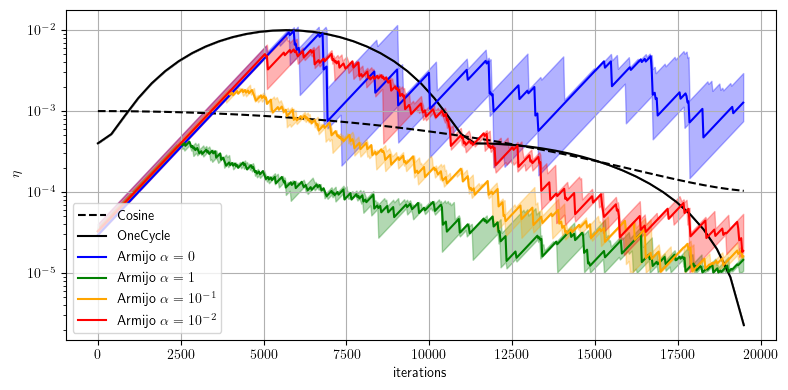

In [132]:
sources_augment = [
    {"path": "ResNet34_CIFAR10_augment_Adam_0.001_CosineAnnealingLR_50_0.0001", "color": "black", "label": "Cosine", "scale": 406, 'linestyle': 'dashed', 'start': 1, 'end': 2},
    {"path": "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "black", "label": "OneCycle", "scale": 406, 'linestyle': 'solid'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1", "color": "green", "label": 'Armijo $ \\alpha = 1$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$'}
]
draw_lr_plot(sources_augment, 'adam_augment', sample=30)

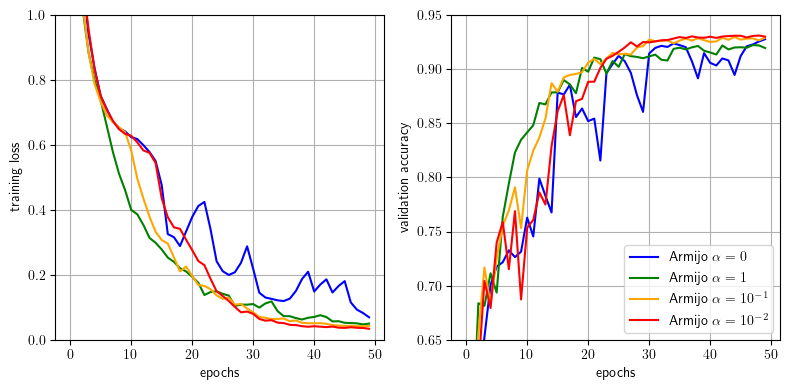

In [10]:
sources = [
#     {"path": "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "red", "label": "OneCycle", "end": 1},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$", "end": 1},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1", "color": "green", "label": 'Armijo $ \\alpha = 1$', "end": 1},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$', "end": 1},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$', "end": 1}
]
draw_loss_acc_plot(sources, 'adam_augment')

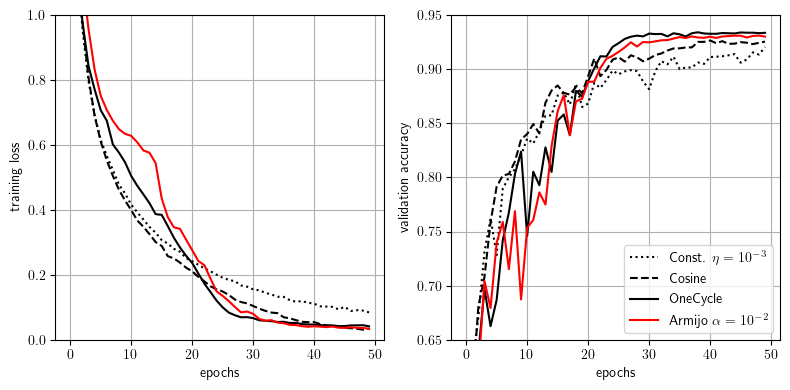

In [645]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_Adam_0.001", "color": "black", "label": "Const. $\eta = 10^{-3}$", "end": 2, "start": 1, 'linestyle': 'dotted'},
    {"path": "ResNet34_CIFAR10_augment_Adam_0.001_CosineAnnealingLR_50_0.0001", "color": "black", "label": "Cosine", "end": 2, "start": 1, 'linestyle': 'dashed'},
    {"path": "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "black", "label": "OneCycle", "end": 1},
#     {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$", "end": 1},
#     {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1", "color": "green", "label": 'Armijo $ \\alpha = 1$', "end": 1},
#     {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$', "end": 1},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$', "end": 1}
]
draw_loss_acc_plot(sources, 'adam_augment_standard')

<Figure size 640x480 with 0 Axes>

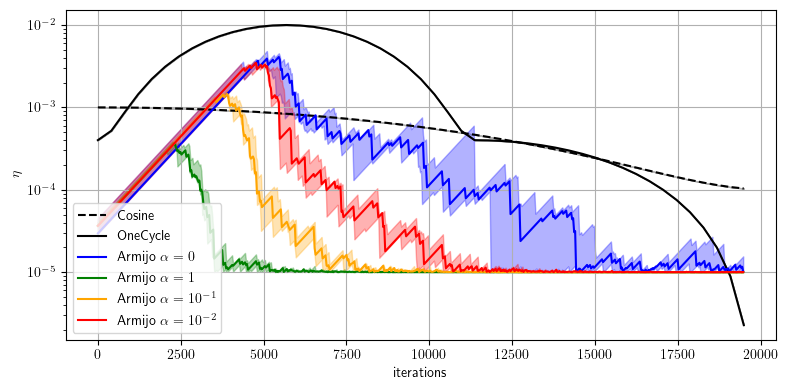

In [133]:
sources = [
    {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001_CosineAnnealingLR_50_0.0001", "color": "black", "label": "Cosine", "scale": 406, 'linestyle': 'dashed'},
    {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "black", "label": "OneCycle", "scale": 406},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$"},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1", "color": "green", "label": 'Armijo $ \\alpha = 1$'},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$'},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$'}
]
draw_lr_plot(sources, 'adam_noaugment', sample=30)

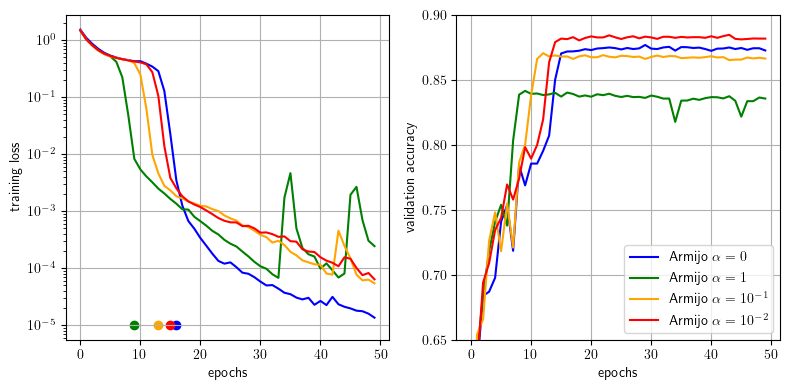

In [11]:
sources = [
#     {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001_CosineAnnealingLR_50_0.0001", "color": "brown", "label": "Cosine", "end": 2, "start": 1},
#     {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "red", "label": "OneCycle", "end": 2, "start": 1},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$", "end": 2, "start": 1},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1", "color": "green", "label": 'Armijo $ \\alpha = 1$', "end": 2, "start": 1},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$', "end": 2, "start": 1},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$', "end":2, "start": 1}
]
draw_loss_acc_plot(sources, 'adam_noaugment', loss_log_scale=True, threshold=0.999, ylim_loss=None, ylim_acc=(0.65, 0.9))

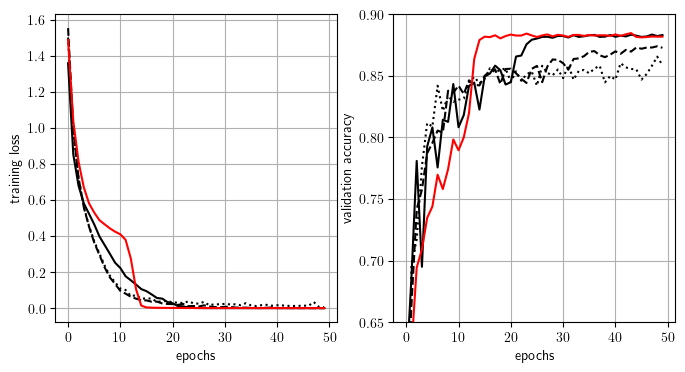

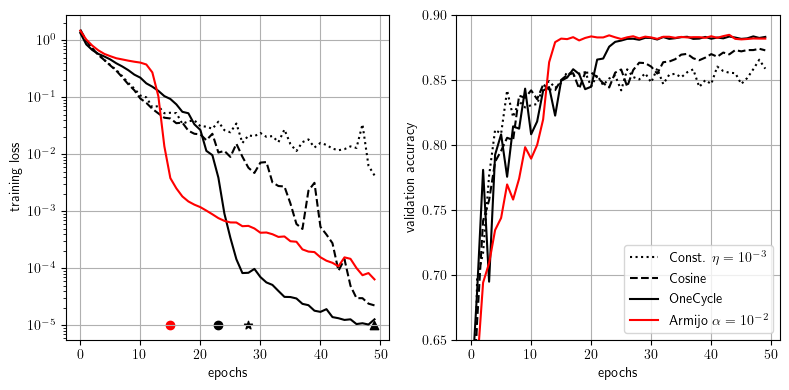

In [13]:
sources = [
    {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001", "color": "black", "label": "Const. $\eta = 10^{-3}$", "end": 2, "start": 1, 'linestyle': 'dotted'},
    {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001_CosineAnnealingLR_50_0.0001", "color": "black", "label": "Cosine", "end": 2, "start": 1, 'linestyle': 'dashed'},
    {"path": "ResNet34_CIFAR10_noaugment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "black", "label": "OneCycle", "end": 2, "start": 1},
#     {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$", "end": 2, "start": 1},
#     {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_1", "color": "green", "label": 'Armijo $ \\alpha = 1$', "end": 2, "start": 1},
#     {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$', "end": 2, "start": 1},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$', "end":2, "start": 1}
]
draw_loss_acc_plot(sources, 'adam_noaugment_standard', loss_log_scale=True, threshold=0.998, ylim_loss=None, ylim_acc=(0.65, 0.9))

<Figure size 640x480 with 0 Axes>

<Figure size 800x400 with 0 Axes>

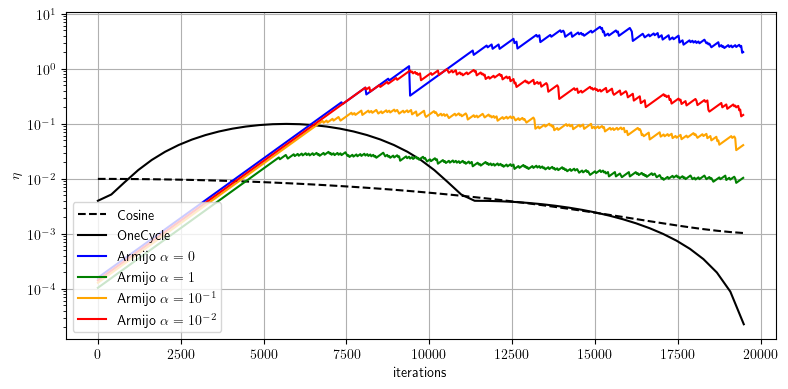

<Figure size 640x480 with 0 Axes>

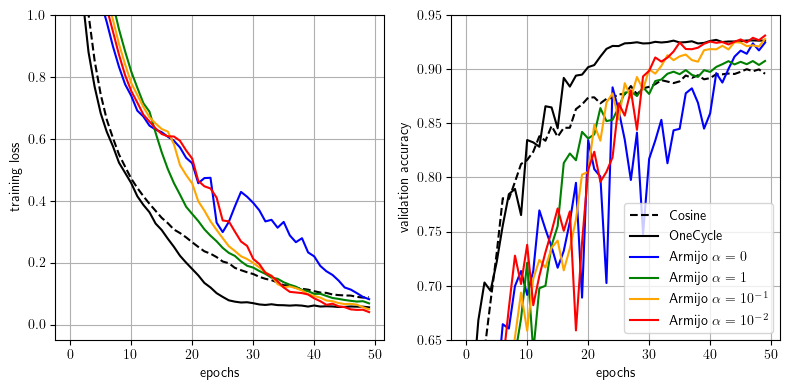

<Figure size 800x400 with 0 Axes>

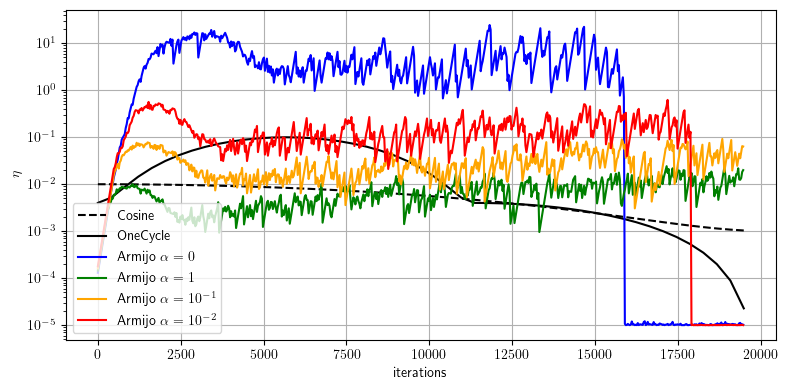

<Figure size 640x480 with 0 Axes>

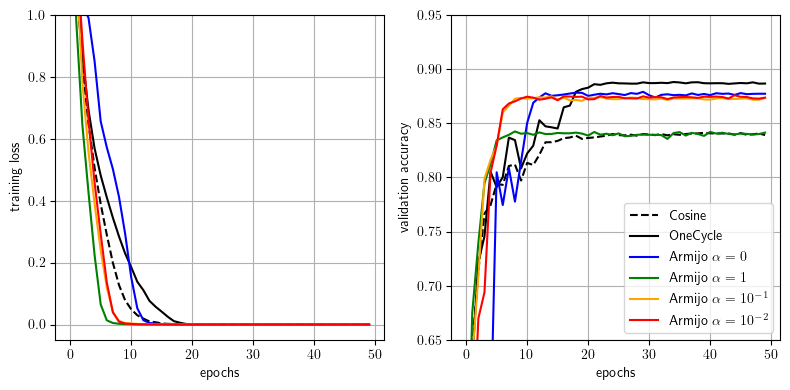

<Figure size 800x400 with 0 Axes>

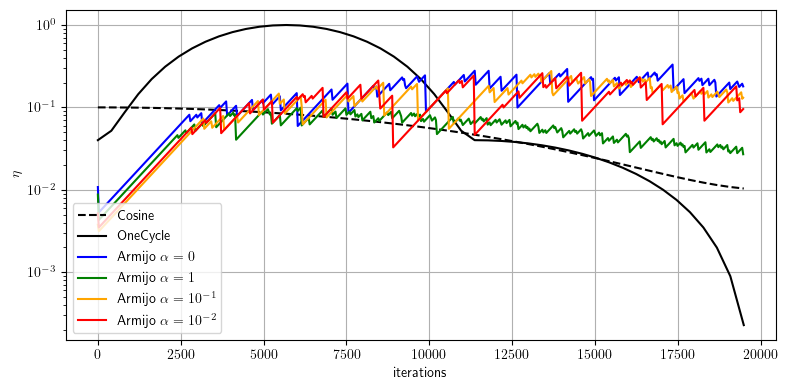

<Figure size 640x480 with 0 Axes>

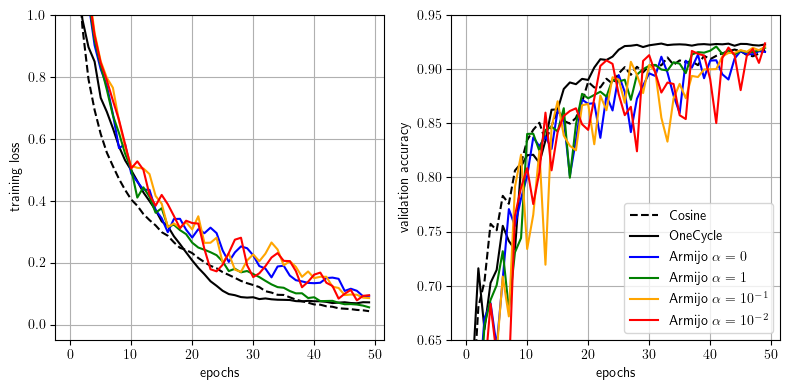

<Figure size 800x400 with 0 Axes>

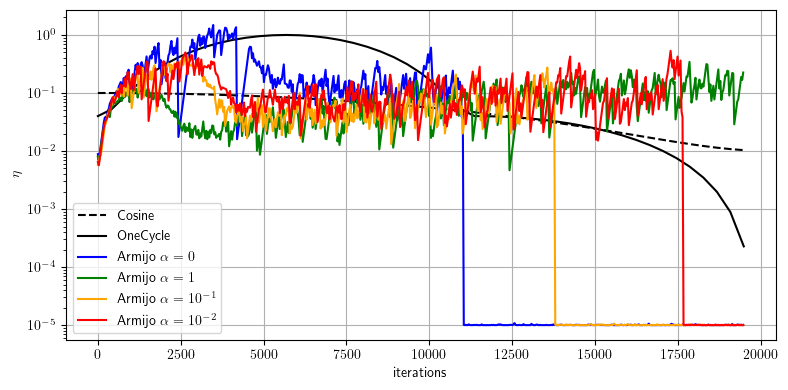

<Figure size 640x480 with 0 Axes>

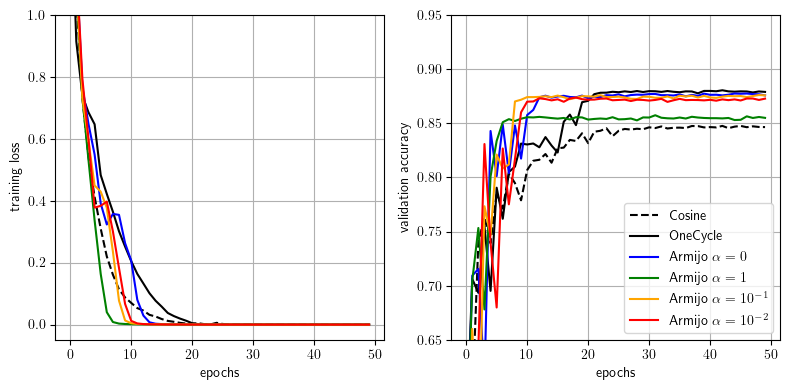

In [134]:
paths = [
    {"name": "adagrad_augment",
     "paths": [
         "ResNet34_CIFAR10_augment_Adagrad_0.01_CosineAnnealingLR_50_0.001",
         "ResNet34_CIFAR10_augment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
         "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
         "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_1",
         "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.1",
         "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.01",
     ]},
    {"name": "adagrad_noaugment",
    "paths": [
        "ResNet34_CIFAR10_noaugment_Adagrad_0.01_CosineAnnealingLR_50_0.001",
        "ResNet34_CIFAR10_noaugment_Adagrad_0.01_OneCycleLR_False_0.1_1_50",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo_0.01",
    ]},
    {"name": "sgd_augment",
    "paths": [
        "ResNet34_CIFAR10_augment_SGD_0.1_CosineAnnealingLR_50_0.01",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.01",
    ]},
    {"name": "sgd_noaugment",
    "paths": [
        "ResNet34_CIFAR10_noaugment_SGD_0.1_CosineAnnealingLR_50_0.01",
        "ResNet34_CIFAR10_noaugment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_0.1",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo_0.01",
    ]}
]

sources = [
    {"color": "black", "label": "Cosine", "scale": 406, 'linestyle': 'dashed'},
    {"color": "black", "label": "OneCycle", "scale": 406, 'linestyle': 'solid'},
    {"color": "blue", "label": "Armijo $ \\alpha = 0$"},
    {"color": "green", "label": 'Armijo $ \\alpha = 1$'},
    {"color": "orange", "label": 'Armijo $ \\alpha = 10^{-1}$'},
    {"color": "red", "label": 'Armijo $ \\alpha = 10^{-2}$'}
]
for entry in paths:
    fig = plt.figure(figsize=(8, 4))
    sources_mod = []
    for path, source in zip(entry['paths'], sources):
        sources_mod.append({
            'path': path,
            **source
        })
    draw_lr_plot(sources_mod, entry['name'], sample=30)
    
    for source in sources_mod:
        if 'scale' in source:
            del source['scale']
            
    draw_loss_acc_plot(sources_mod, entry['name'], ylim_loss=(-0.05, 1), ylim_acc=(0.65, 0.95))

<Figure size 640x480 with 0 Axes>

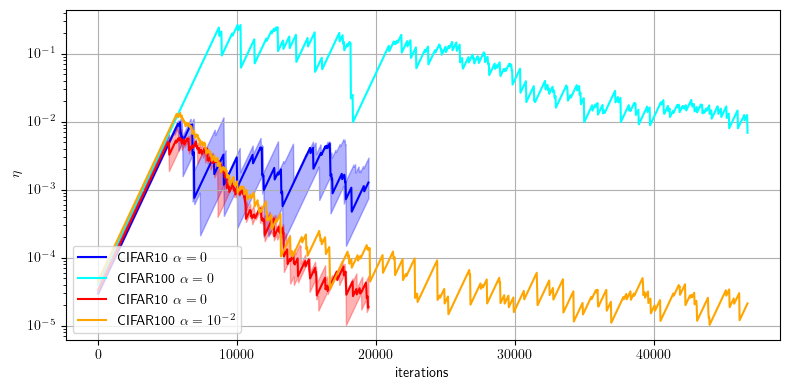

In [145]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "CIFAR10 $\\alpha=0$"},
    {"path": "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_test", "color": "cyan", "label": "CIFAR100 $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01", "color": "red", "label": "CIFAR10 $\\alpha=0$"},
    {"path": "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01_test", "color": "orange", "label": "CIFAR100 $\\alpha=10^{-2}$"},
]
draw_lr_plot(sources, 'adam_augment_cifar100', sample=30)

## Normalization

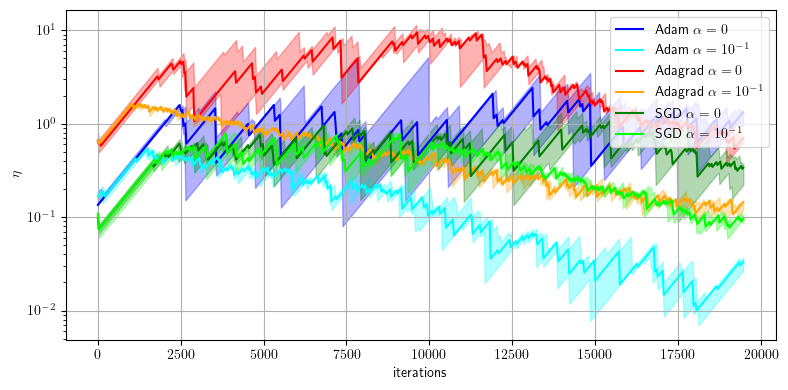

In [135]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo", "color": "blue", "label": "Adam $\\alpha=0$",},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1", "color": "cyan", "label": "Adam $\\alpha=10^{-1}$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo", "color": "red", "label": "Adagrad $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1", "color": "orange", "label": "Adagrad $\\alpha=10^{-1}$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo", "color": "green", "label": "SGD $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1", "color": "lime", "label": "SGD $\\alpha=10^{-1}$"}
]
draw_lr_plot(sources, 'normalized_augment', legend_loc='upper right', sample=30)

<Figure size 640x480 with 0 Axes>

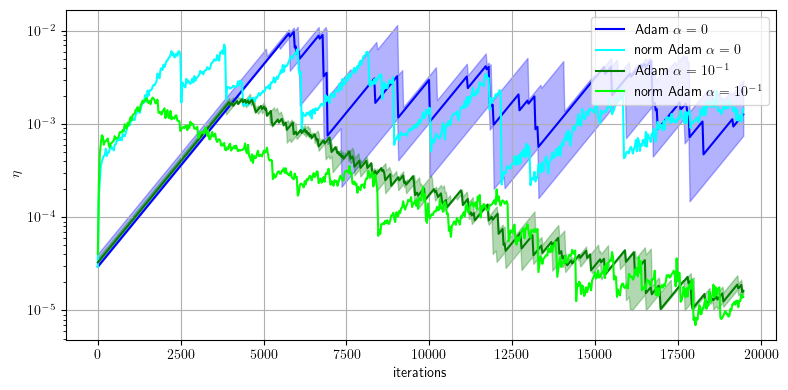

In [136]:
def unnormalize_lr(obj):
    if 'direction_length/train' in obj and len(obj['direction_length/train']) > 0:
        return np.array(obj['lr/train']) / np.array(obj['direction_length/train'])
    else:
        return np.array(obj['lr/train'])
sources = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Adam $\\alpha=0$",},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo", "color": "cyan", "label": "norm Adam $\\alpha=0$", "start": 3, "end": 4},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "green", "label": "Adam $\\alpha=10^{-1}$",},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1", "color": "lime", "label": "norm Adam $\\alpha=10^{-1}$", "start": 3, "end": 4},
]
draw_lr_plot(sources, 'normalized_compare', extraction_function=unnormalize_lr, legend_loc='upper right', sample=30)

<Figure size 640x480 with 0 Axes>

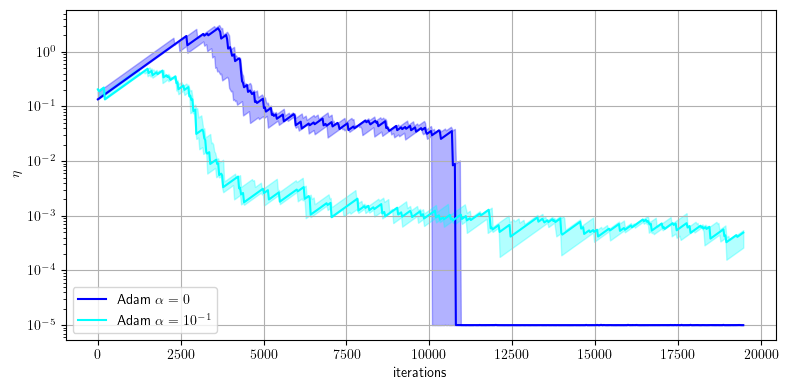

In [137]:
sources = [
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo", "color": "blue", "label": "Adam $\\alpha=0$",},
    {"path": "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1", "color": "cyan", "label": "Adam $\\alpha=10^{-1}$"},
]
draw_lr_plot(sources, 'normalized_noaugment', sample=30)
# fig = plt.figure(figsize=(8, 4))
# get_plot(plt, sources_augment, 'lr/train')
# plt.yscale('log')
# plt.ylabel('$\eta$')
# plt.xlabel('iterations')
# plt.legend()
# plt.tight_layout()
# plt.savefig('paper/figures/armijo/normalized_noaugment_lr.pdf')
# plt.show()
# plt.clf()
# get_value(sources_augment, 'num_iterations/train', 0)

In [691]:
help(get_stats)

Help on function get_stats in module __main__:

get_stats(sources, rows, columns=['Adam', 'Adagrad', 'SGD'], extraction_function=<function <lambda> at 0x7f80214b8160>)



<Figure size 640x480 with 0 Axes>

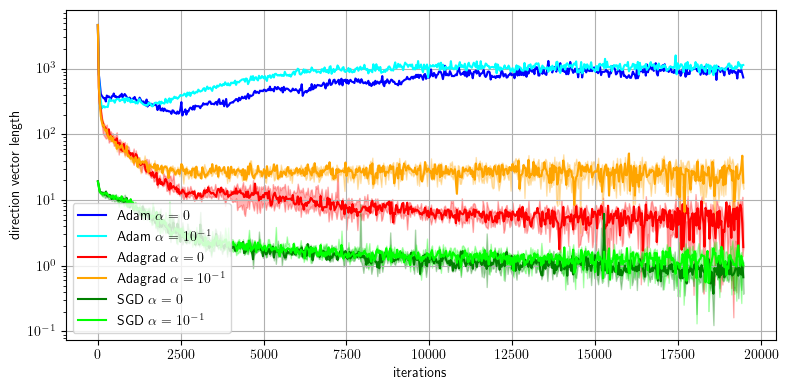

Adam $\alpha=0$ 4612.93310546875
Adam $\alpha=10^{-1}$ 4612.927734375
Adagrad $\alpha=0$ 4613.25048828125
Adagrad $\alpha=10^{-1}$ 4613.25048828125
SGD $\alpha=0$ 19.3536376953125
SGD $\alpha=10^{-1}$ 19.879281997680664


In [138]:
sources_augment = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo", "color": "blue", "label": "Adam $\\alpha=0$", "start": 3, "end": 4},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1", "color": "cyan", "label": "Adam $\\alpha=10^{-1}$", "start": 3, "end": 4},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo", "color": "red", "label": "Adagrad $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1", "color": "orange", "label": "Adagrad $\\alpha=10^{-1}$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo", "color": "green", "label": "SGD $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1", "color": "lime", "label": "SGD $\\alpha=10^{-1}$"}
]
fig = plt.figure(figsize=(8, 4))
get_plot(plt, sources_augment, 'direction_length/train', sample=30)
plt.yscale('log')
plt.ylabel('direction vector length')
plt.xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.savefig('paper/figures/armijo/normalized_augment_dir_len.pdf')
plt.show()
plt.clf()
for entry in sources_augment:
    path = entry['path'] + "_" + str(entry.get('start', 0))
    obj = read_json(f'results/{path}/stats.json')
    print(entry['label'], np.max(obj['direction_length/train']))

In [696]:
(1e8/4)**0.5

5000.0

In [ ]:
###### sources = [
#     {"path": "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50", "color": "red", "label": "OneCycle", "end": 1},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Armijo $ \\alpha = 0$", "end": 3},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo", "color": "cyan", "label": 'norm Armijo $ \\alpha = 0$', "end": 3},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.1", "color": "red", "label": 'Armijo $ \\alpha = 10^{-1}$', "end": 3},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.1", "color": "orange", "label": 'norm Armijo $ \\alpha = 10^{-1}$', "end": 3}
]
draw_loss_acc_plot(sources, 'normalized_augment_adam')

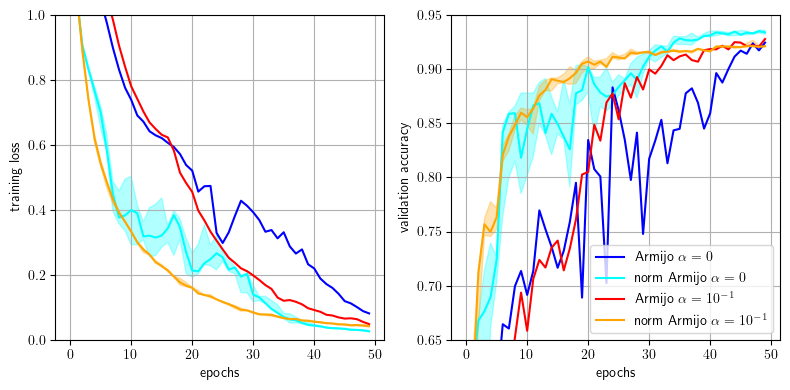

In [655]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo", "color": "blue", "label": "Armijo $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo", "color": "cyan", "label": "norm Armijo $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo_0.1", "color": "red", "label": "Armijo $\\alpha=10^{-1}$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_normalize_increase_armijo_0.1", "color": "orange", "label": "norm Armijo $\\alpha=10^{-1}$"},
]
draw_loss_acc_plot(sources, 'normalized_augment_adagrad')

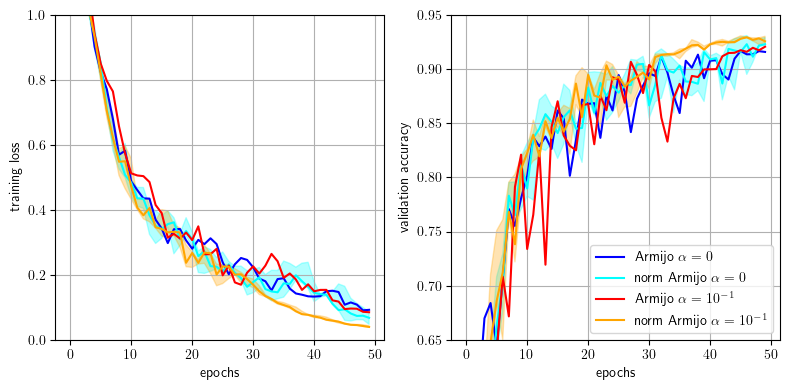

In [656]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo", "color": "blue", "label": "Armijo $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo", "color": "cyan", "label": "norm Armijo $\\alpha=0$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo_0.1", "color": "red", "label": "Armijo $\\alpha=10^{-1}$"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_normalize_increase_armijo_0.1", "color": "orange", "label": "norm Armijo $\\alpha=10^{-1}$"},
]
draw_loss_acc_plot(sources, 'normalized_augment_sgd')

## Double

In [18]:
sources = [
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_double_0.5_1.001_Adam_1_increase_armijo",
    ],
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_double_0.1_1.001_Adagrad_1_increase_armijo"
    ],
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_double_0.1_1.001_SGD_1_increase_armijo",
    ]
]

rows = [
    'Single batch',
    'Double batches',
]

get_stats(sources, rows=rows)
get_stats(sources, rows=rows, extraction_function = lambda a: np.max(a['acc/val']))

get_stats(sources, rows=rows, extraction_function=extract_number_of_critical_points)

from collections import Counter

def percentage_of_negative_directions(a):
    a = np.array(a['num_iterations/train'])
    print(Counter(a))
    return np.sum(a == -1)/(a.shape[0])

get_stats(sources, rows=rows, extraction_function=percentage_of_negative_directions)

\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &           SGD \\
\midrule
Single batch   &  $\bm{0.927 \pm 0.016}$ &  $\bm{0.924}$ &  $\bm{0.916}$ \\
Double batches &                 $0.791$ &       $0.602$ &       $0.524$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &                    Adam &       Adagrad &           SGD \\
\midrule
Single batch   &  $\bm{0.927 \pm 0.002}$ &  $\bm{0.924}$ &  $\bm{0.917}$ \\
Double batches &                 $0.791$ &       $0.602$ &       $0.525$ \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} &                Adam &        Adagrad &            SGD \\
\midrule
Single batch   &  $25.000 \pm 0.000$ &  $\bm{63.000}$ &  $\bm{58.000}$ \\
Double batches &       $\bm{50.000}$ &       $33.000$ &       $31.000$ \\
\bottomrule
\end{tabular}

Counter({0.0: 19475, 1.0: 11, 6.0: 2, 2.0: 2, 4.0: 2, 99.0: 1, 13.0: 1, 31.0: 1, 10.0: 1, 20.0: 1, 3.0: 1, 9.0: 1, 33.0: 1})
Counter({0.0: 19475, 1.0: 6, 2.0

<Figure size 640x480 with 0 Axes>

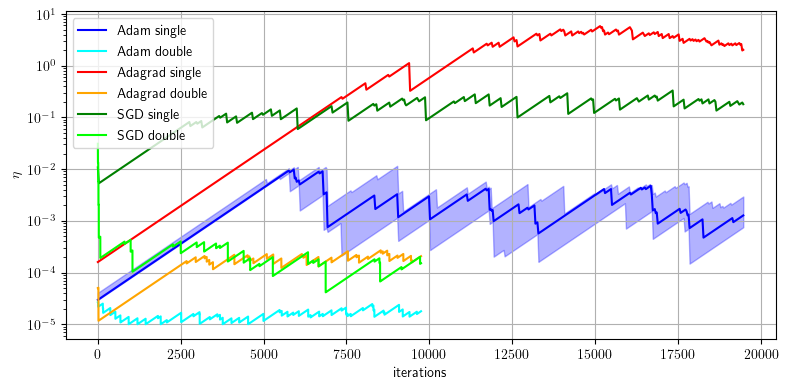

<Figure size 640x480 with 0 Axes>

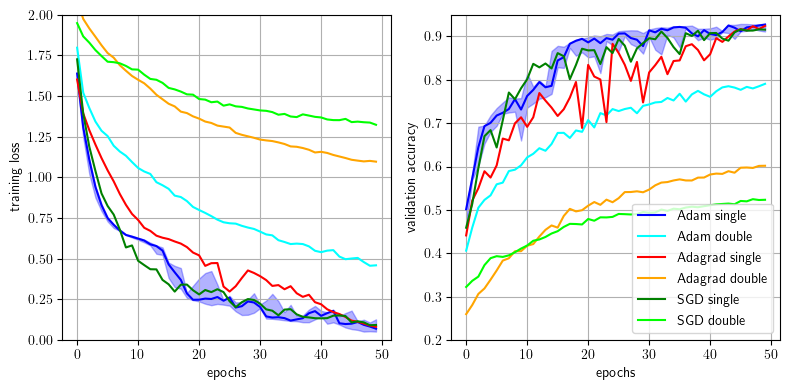

In [139]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label": "Adam single"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_double_0.5_1.001_Adam_1_increase_armijo", "color": "cyan", "label": "Adam double"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo", "color": "red", "label": "Adagrad single"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_double_0.1_1.001_Adagrad_1_increase_armijo", "color": "orange", "label": "Adagrad double"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo", "color": "green", "label": "SGD single"},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_double_0.1_1.001_SGD_1_increase_armijo", "color": "lime", "label": "SGD double"},
]
for source in sources:
    if 'double' in source['path']:
        source['scale'] = 1
draw_lr_plot(sources, 'double', legend_loc='upper left', sample=30)
for source in sources:
    if 'double' in source['path']:
        source['scale'] = 1
draw_loss_acc_plot(sources, 'double', ylim_loss=(0, 2), ylim_acc = (0.2, 0.95))

In [141]:
def rolling_f(f, k, array):
    return np.array([f(array[i:i+k]) for i in range(len(array)-k+1)])

mean of running medians: 0.1549990349496021
mean: 0.15531445643582784
std of mean: 0.00027111212051492486
mean of running medians: 0.004064821062802236
mean: 0.004072815430293335
std of mean: 0.00016954252407343852
mean of running medians: 0.5273142833043593
mean: 0.5256628524187283
std of mean: 0.0002124832966380793
mean of running medians: 0.004892485197637131
mean: 0.005183673141605258
std of mean: 0.00018264183819224387
mean of running medians: 1.0
mean: 1.000000002738757
std of mean: 3.0158495856234394e-10
mean of running medians: 0.004825046119870723
mean: 0.0048986199262630505
std of mean: 0.00040608837626970564


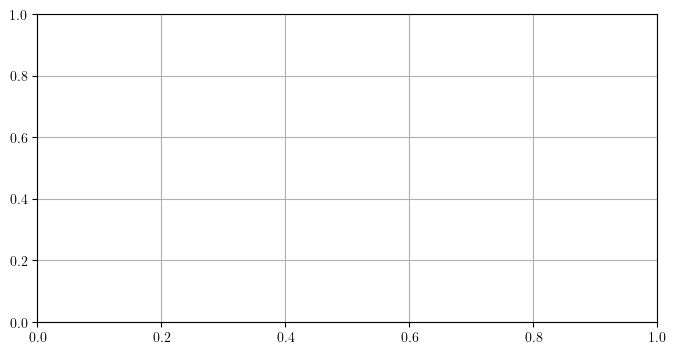

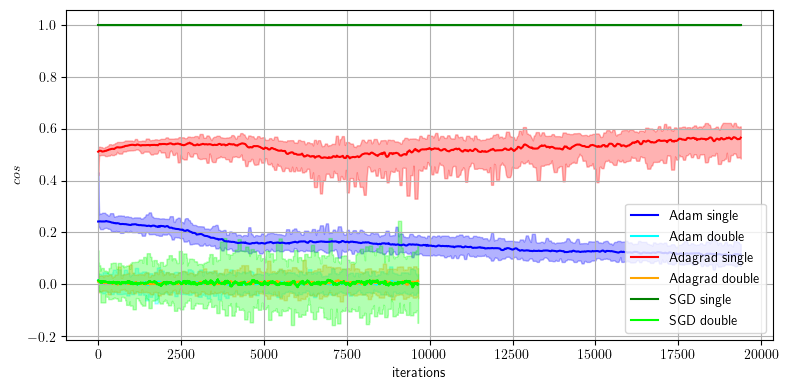

In [142]:
k = 100
def transform(x):
    x = x.mean(axis=0)
    x_min = rolling_f(np.min, k, x)
    x_median = rolling_f(np.median, k, x)
    x_max = rolling_f(np.max, k, x)
    print("mean of running medians:", x_median.mean())
    print("mean:", x.mean())
    print("std of mean:", x.std()/x.shape[0]**0.5)
    return np.stack((x_min, x_median, x_max), axis=0)
for source in sources:
    if 'double' in source['path']:
        source['scale'] = 1
fig = plt.figure(figsize=(8, 4))
get_plot(plt, sources, 'cosine/train', transform_data=transform, sample=30)
plt.ylabel('$cos$')
plt.xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.savefig(f'paper/figures/armijo/double_cos.pdf')
plt.show()
plt.clf()

## Profiles

In [57]:
import math

def draw_profiles_with_armijo(profiles, lrs, losses):
    m = math.ceil(profiles.shape[0]**0.5)
    fig, axs = plt.subplots(m, m, figsize=(2*m, 2*m))
    for i, (profile, loss) in enumerate(zip(profiles, losses)):
        real, approx = profile[:,0], profile[:,1]
#         slope = (approx[-1] - approx[0])/(lrs[-1] - lrs[0])
        
#         print(approx[-1] - approx[0], (lrs[-1] - lrs[0]))
#         print(slope)
#         approx0 = approx[0] - lrs[0]*slope
#         real0 = real[0] - lrs[0]*2*slope
#         print(approx0, real0)
#         print(approx[0], real[0])
#         break
#         approx = real_0 + lrs*slope
#         print(real0, real[0], approx[0])
        n = np.max(np.where(approx >= real)) + 5
#         print("n:", n)
#         print(lrs[np.argmin(real)])
        real = [loss] + list(real[:n])
        approx = [loss] + list(approx[:n])
        local_lrs = [0] + list(lrs[:n])
        print(i//m, i%m)
        axs[i//m, i%m].plot(local_lrs, real, color='blue')
        axs[i//m, i%m].plot(local_lrs, approx, color='red')
    
    plt.tight_layout()
    plt.show()
    plt.clf()
#     ns = []
#     for i, direction in enumerate(directions):
#         convexity, batch_size, real, _, approx, _ = data[direction]
#         approx = np.array(approx)
#         approx = real[0] + C*(approx-approx[0])
#         try:
#         except:
#             n = real.shape[0]
# #         n = np.argmin(real)+5
# #         ns.append(n)
# #         n = thresholds[line][i]
#         real = real[:n]|
#         approx = approx[:n]
#         local_lrs = lrs[:n]
# #         line_y = ((lrs[-1] - lrs)*real[0] + (lrs - lrs[0])*real[-1])/(lrs[-1]-lrs[0])
# #         ax[line, i].plot(local_lrs, line_y)
#         ax[line, i].plot(local_lrs, real, color='blue')
#         ax[line, i].plot(local_lrs, approx, color='red')
#         ax[line, i].set_title(f'${convexity:.2f}$', fontsize=14)
# #         ax[line, i].tick_params(axis='x', bottom=False, labelbottom=False, which='both')
# #         ax[line, i].tick_params(axis='y', left=False, labelleft=False, which='both')
#         ticks = np.array([1, 2, 5]*7) * 10**np.tile(np.arange(-5, 2, dtype=np.float).reshape(-1, 1), (1, 3)).flatten()
#         tick = ticks[np.argmax(np.arange(ticks.size)[ticks <= 1.1*local_lrs[-1]])]
#         ax[line, i].set_xticks([tick])
#         ax[line, i].set_yticks([])

In [58]:
def get_profile_convexity(real, lrs):
    convex_condition = (lrs[1:-1] - lrs[:-2]) * real[2:] + (lrs[2:] - lrs[1:-1]) * real[:-2] - (lrs[2:] - lrs[:-2]) * real[1:-1]
    convex = np.mean(convex_condition + np.abs(convex_condition)/100 >= 0)
    convex_total = 0
    total = 0
    for a in range(len(real)):
        for b in range(a+1, len(real)):
            for c in range(b+1, len(real)):
                convex_total += (((lrs[b]-lrs[a]) * real[c] + (lrs[c]-lrs[b]) * real[a] - (lrs[c]-lrs[a]) * real[b]) > 0)
                total+=1
    convex_total/=total
    return convex, convex_total

In [67]:
def show_profiles_minima(path, name, check_convexity=False, draw_profiles=False):
    obj = read_json(f'results/{path}/stats.json')
    profile_type = np.array(obj['profile_type/train'])
    profile_type_12 = profile_type[profile_type > 0]
    profile_type_t1 = np.where(profile_type == 1)[0]
    profile_type_t2 = np.where(profile_type == 2)[0]
    profile_type_t = np.where(profile_type > 0)[0]
    
    profile_n = 71
    
    lrs = np.exp(np.linspace(np.log(1e-5), np.log(100), profile_n))
    profiles = np.array(obj['profile/train'])
    real = profiles[:,:,0]
    approx = profiles[:,:,1]
    minima = lrs[real.argmin(axis=1)]
    
    critical_minima = minima[profile_type_12 == 1]
    other_minima = minima[profile_type_12 == 2]
            
    ids = np.tile(np.arange(profile_n), profiles.shape[0]).reshape(-1, profile_n)
    armijo_minima = []
    for r, a in zip(real, approx):
        try:
            armijo_minima.append(np.arange(profile_n)[r <= a+1e-5][-1])
        except:
            armijo_minima.append(10)
    armijo_minima = lrs[np.array(armijo_minima)]
    
    armijo_critical_minima = armijo_minima[profile_type_12 == 1]
    armijo_other_minima = armijo_minima[profile_type_12 == 2]
    
    fig = plt.figure(figsize=(8, 4))
    plt.scatter(profile_type_t2, other_minima, color='green', label='Non-critical minima')
    plt.scatter(profile_type_t2, armijo_other_minima, color='lime', label='Non-critial Armijo')
    plt.scatter(profile_type_t1, critical_minima, color='red', label='Critical minima')
    plt.scatter(profile_type_t1, armijo_critical_minima, color='orange', label='Critical Armijo')
    
    
    lr = np.array(obj['lr/train'])
    plt.plot(np.arange(lr.shape[0]), lr)
    
    print("Critical minima:", critical_minima.shape)
    ratio = minima/lr[profile_type_t]
    print("Mean ratio =", np.exp(np.mean(np.log(ratio))), np.mean(ratio))
    print("Mean ratio with Armijo:")
    critical_ratio = critical_minima/armijo_critical_minima
    ratio = minima/armijo_minima
    print("Critical =", np.exp(np.mean(np.log(critical_ratio))), np.mean(critical_ratio))
    print("All =", np.exp(np.mean(np.log(ratio))), np.mean(ratio))
    
    
    plt.yscale('log')
    plt.ylabel('$\eta$')
    plt.xlabel('iterations')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'paper/figures/armijo/{name}_critical_lr.pdf')
    plt.show()
    plt.clf()
    
    if check_convexity:
        convexity = []
        for real_profile in real:
            convexity.append(get_profile_convexity(real_profile[:61], lrs[:61]))
        convexity = np.array(convexity)
        avg_critical_convexity = convexity[profile_type_12 == 1].mean(axis=0)
        avg_all_convexity = convexity.mean(axis=0)
        print(avg_critical_convexity, avg_all_convexity, avg_critical_convexity/avg_all_convexity)
    
    if draw_profiles:
        draw_profiles_with_armijo(profiles[profile_type_12 == 1], lrs, np.array(obj['loss_detailed/train'])[profile_type == 1])

Critical minima: (23,)
Mean ratio = 8.786506959600397 14.246566881600785
Mean ratio with Armijo:
Critical = 10.513301770262386 16.34277513916614
All = 2.522054028439103 3.8184760123236585


<Figure size 640x480 with 0 Axes>

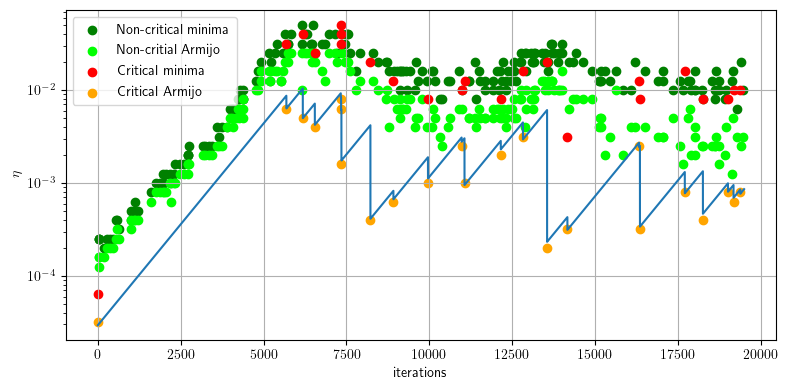

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2


<Figure size 640x480 with 0 Axes>

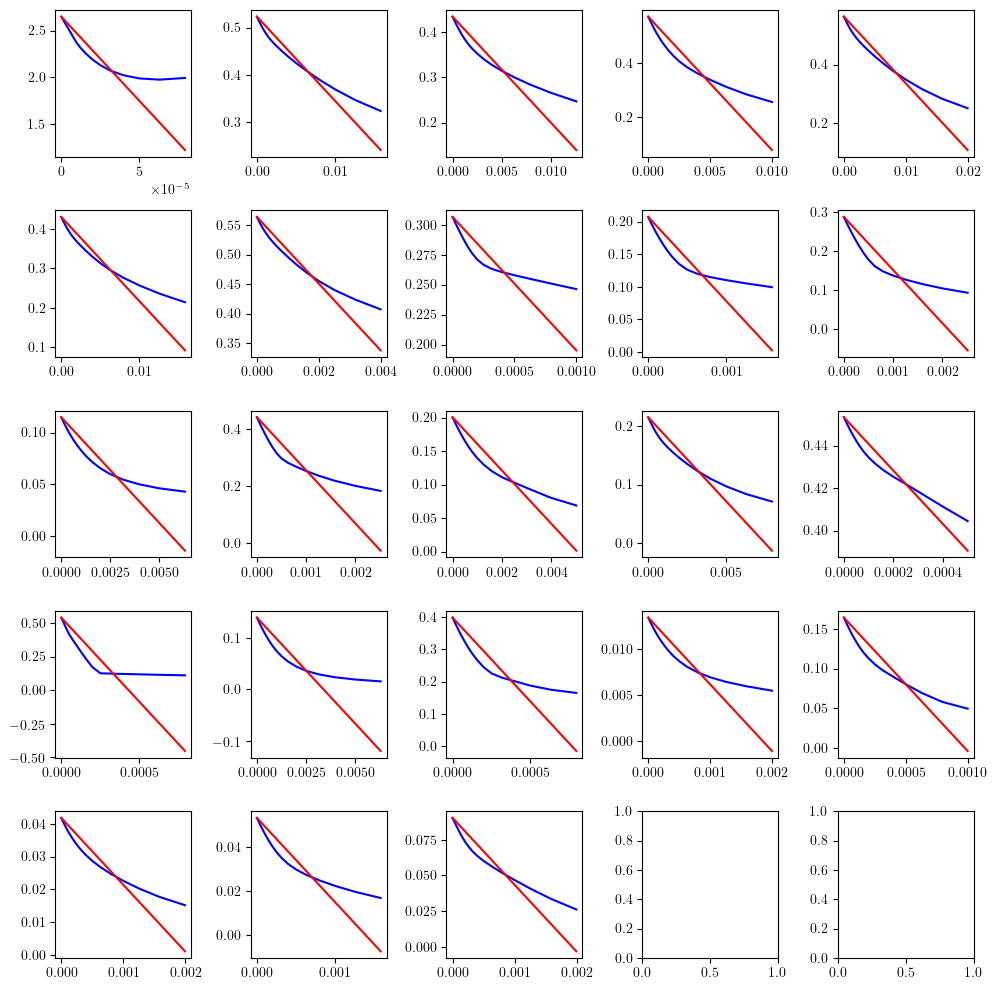

In [68]:
show_profiles_minima(
    'ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_0.01_True_increase_armijo_critical_prof_0',
    'adam_augment',
    draw_profiles=True
)
# think of strong convexity of the profiles

In [61]:
obj = read_json("results/ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_8.8_increase_armijo_0/stats.json")
a = np.array(obj['acc/val'])
print(a[-1], np.max(a))

obj = read_json("results/ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0/stats.json")
a = np.array(obj['acc/val'])
print(a[-1], np.max(a))

0.9075521230697632 0.921875
0.9274839758872986 0.9274839758872986


Critical minima: (60,)
Mean ratio = 79.08772721588447 825.6322685355702
Mean ratio with Armijo:
Critical = 4.200812845890067 17.539573352614177
All = 2.509426431675321 7.987460335471376


<Figure size 640x480 with 0 Axes>

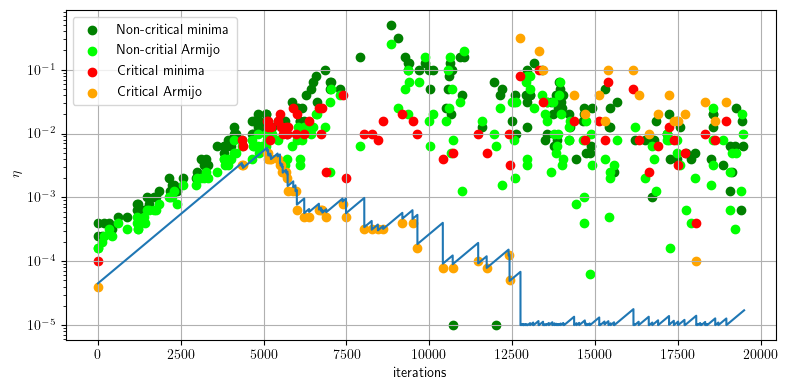

In [69]:
show_profiles_minima('ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adam_1_0.01_True_increase_armijo_critical_prof_0', 'adam_noaugment')


Critical minima: (57,)
Mean ratio = 1.3936139019287266 1.5951846369434173
Mean ratio with Armijo:
Critical = 1.0412232560483055 1.1833385480399394
All = 0.744127765482806 0.8195378100619466


<Figure size 640x480 with 0 Axes>

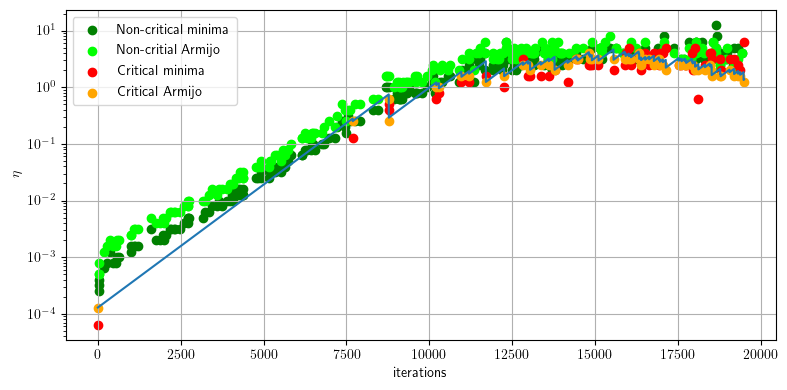

In [70]:
show_profiles_minima(
    "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_0.01_True_increase_armijo_critical_prof_0",
    "adagrad_augment"
)

## Ablation

In [668]:
def sum_armijo_iterations(a):
    a = np.array(a['num_iterations/train'])
    a[a == -1] = 0
    a += 1
    return np.mean(a)

In [669]:
sources_augment = [
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.01_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.01_Adam_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_Adam_1_keep_goldstein",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.2_Adam_1_keep_goldstein"
    ],
    [
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_Adagrad_1_keep_goldstein",
        "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.2_Adagrad_1_keep_goldstein"
    ]
]
rows = [
    '$c=0.5, \gamma=1.001$',
    '$c=0.5, \gamma=1.01$',
    '$c=0.1, \gamma=1.001$',
    '$c=0.1, \gamma=1.01$',
    '$c=0.1$, goldstein',
    '$c=0.2$, goldstein'
]
columns = [
    'Adam',
    'Adagrad'
]
get_stats(sources_augment, rows=rows, columns=columns)
get_stats(sources_augment, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))
get_stats(sources_augment, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/train']))
get_stats(sources_augment, rows=rows, columns=columns, extraction_function=sum_armijo_iterations)

\begin{tabular}{lll}
\toprule
{} &                    Adam &       Adagrad \\
\midrule
$c=0.5, \gamma=1.001$ &  $\bm{0.927 \pm 0.016}$ &       $0.836$ \\
$c=0.5, \gamma=1.01$  &       $0.869 \pm 0.018$ &       $0.859$ \\
$c=0.1, \gamma=1.001$ &       $0.922 \pm 0.017$ &  $\bm{0.924}$ \\
$c=0.1, \gamma=1.01$  &       $0.637 \pm 0.172$ &       $0.913$ \\
$c=0.1$, goldstein    &       $0.916 \pm 0.010$ &           $-$ \\
$c=0.2$, goldstein    &       $0.860 \pm 0.063$ &           $-$ \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
{} &                    Adam &       Adagrad \\
\midrule
$c=0.5, \gamma=1.001$ &  $\bm{0.927 \pm 0.002}$ &       $0.836$ \\
$c=0.5, \gamma=1.01$  &       $0.892 \pm 0.008$ &       $0.860$ \\
$c=0.1, \gamma=1.001$ &       $0.926 \pm 0.004$ &  $\bm{0.924}$ \\
$c=0.1, \gamma=1.01$  &       $0.840 \pm 0.017$ &       $0.913$ \\
$c=0.1$, goldstein    &       $0.922 \pm 0.010$ &           $-$ \\
$c=0.2$, goldstein    &       $0.872 \pm 0.057$ &           $-

<Figure size 640x480 with 0 Axes>

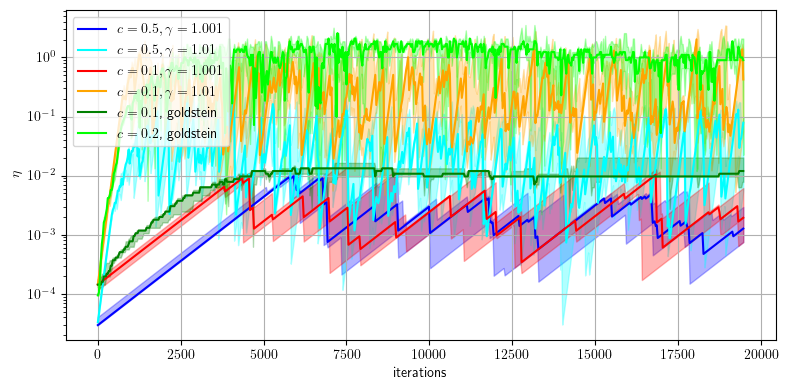

<Figure size 640x480 with 0 Axes>

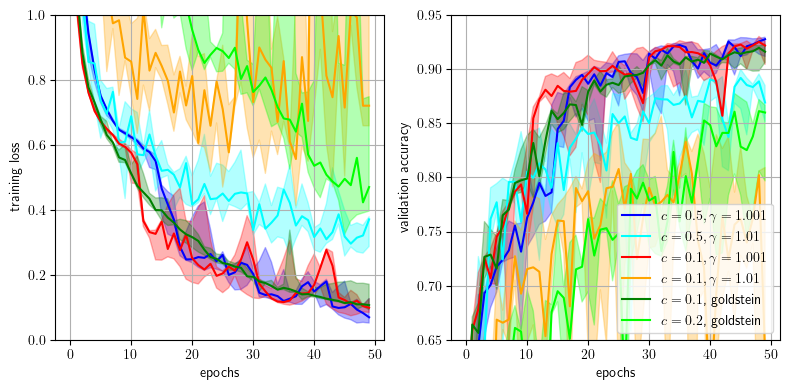

In [143]:
sources_augment = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo", "color": "blue", "label":     '$c=0.5, \gamma=1.001$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.01_Adam_1_increase_armijo", "color": "cyan", "label":     '$c=0.5, \gamma=1.01$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adam_1_increase_armijo", "color": "red", "label":     '$c=0.1, \gamma=1.001$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.01_Adam_1_increase_armijo", "color": "orange", "label":     '$c=0.1, \gamma=1.01$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_Adam_1_keep_goldstein", "color": "green", "label":     '$c=0.1$, goldstein'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.2_Adam_1_keep_goldstein", "color": "lime", "label":     '$c=0.2$, goldstein'},
]
draw_lr_plot(sources_augment, 'ablation_adam', legend_loc='upper left', sample=30)

draw_loss_acc_plot(sources_augment, 'ablation_adam_loss')

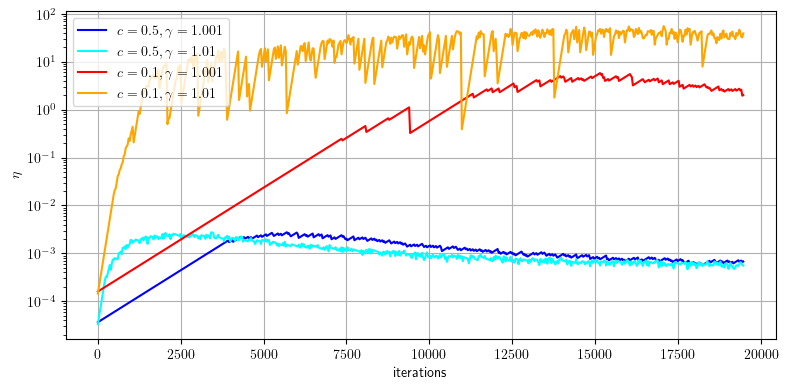

In [144]:
sources_augment = [
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.001_Adagrad_1_increase_armijo", "color": "blue", "label":     '$c=0.5, \gamma=1.001$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.5_1.01_Adagrad_1_increase_armijo", "color": "cyan", "label":     '$c=0.5, \gamma=1.01$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo", "color": "red", "label":     '$c=0.1, \gamma=1.001$'},
    {"path": "ResNet34_CIFAR10_augment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo", "color": "orange", "label":     '$c=0.1, \gamma=1.01$'},
]
draw_lr_plot(sources_augment, 'ablation_adagrad', legend_loc='upper left', sample=30)

In [671]:
sources_noaugment = [
    [
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.001_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_Adagrad_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_Adagrad_1_keep_goldstein",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.2_Adagrad_1_keep_goldstein"
    ],
    [
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.5_1.01_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.001_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_1.01_SGD_1_increase_armijo",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.1_SGD_1_keep_goldstein",
        "ResNet34_CIFAR10_noaugment_ArmijoLineSearch_single_0.2_SGD_1_keep_goldstein"
    ]
]
rows = [
    '$c=0.5, \gamma=1.001$',
    '$c=0.5, \gamma=1.01$',
    '$c=0.1, \gamma=1.001$',
    '$c=0.1, \gamma=1.01$',
    '$c=0.1$, goldstein',
    '$c=0.2$, goldstein'
]
columns = [
    'Adagrad',
    'SGD'
]
get_stats(sources_noaugment, rows=rows, columns=columns)
get_stats(sources_noaugment, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))
get_stats(sources_noaugment, rows=rows, columns=columns, extraction_function=lambda a: a['acc/train'][-1])
get_stats(sources_noaugment, rows=rows, columns=columns, extraction_function=sum_armijo_iterations)

\begin{tabular}{lll}
\toprule
{} &       Adagrad &                SGD \\
\midrule
$c=0.5, \gamma=1.001$ &       $0.496$ &  $0.643 \pm 0.004$ \\
$c=0.5, \gamma=1.01$  &       $0.595$ &            $0.676$ \\
$c=0.1, \gamma=1.001$ &       $0.590$ &            $0.839$ \\
$c=0.1, \gamma=1.01$  &  $\bm{0.877}$ &       $\bm{0.876}$ \\
$c=0.1$, goldstein    &       $0.527$ &            $0.717$ \\
$c=0.2$, goldstein    &       $0.533$ &            $0.679$ \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
{} &       Adagrad &                SGD \\
\midrule
$c=0.5, \gamma=1.001$ &       $0.510$ &  $0.652 \pm 0.002$ \\
$c=0.5, \gamma=1.01$  &       $0.607$ &            $0.686$ \\
$c=0.1, \gamma=1.001$ &       $0.596$ &            $0.842$ \\
$c=0.1, \gamma=1.01$  &  $\bm{0.879}$ &       $\bm{0.877}$ \\
$c=0.1$, goldstein    &       $0.541$ &            $0.728$ \\
$c=0.2$, goldstein    &       $0.541$ &            $0.688$ \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
{} &    

## Experts linearized

In [4]:
sources = [
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_0.01_Adam_1_1_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_0.1_Adam_1_1_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_normalize_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_normalize_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_Adam_1_0_0.1_0.0001_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_Adam_1_1_0.1_0.0001_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_Adam_1_0_0.1_0.0001_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_Adam_1_1_0.1_0.0001_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_0_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_0_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_1_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_0_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_1_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_0_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_1_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_0_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_1_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_0_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_1_0.1_0.0001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_0_1_0.001_100_0",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_1_1_0.001_100_0",
]
res = []
for path in sources:
    full_path = f'results/{path}/stats.json'
    obj = read_json(full_path)
    res.append((path, np.max(obj['acc/val'])))

res = sorted(res, key=lambda x: x[1])
res

[('SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_normalize_100_0',
  0.5940504670143127),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_1_1_0.001_100_0',
  0.6207932829856873),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_0_1_0.001_100_0',
  0.6226963400840759),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_1_1_0.001_100_0',
  0.6460336446762085),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_1_1_0.001_100_0',
  0.6595553159713745),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_0_1_0.001_100_0',
  0.6638621687889099),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_normalize_100_0',
  0.6708734035491943),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_100_0',
  0.7053285241127014),
 ('SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_0_1_0.001_100_0',
  0.7374799847602844),
 ('SmallResnet20_CIFAR10

In [14]:
sources = [
    [
        "SmallResnet20_CIFAR10_augment_Adam_1",
        "SmallResnet20_CIFAR10_augment_Adam_0.1",
        "SmallResnet20_CIFAR10_augment_Adam_0.01",
        "SmallResnet20_CIFAR10_augment_Adam_0.001",
        "SmallResnet20_CIFAR10_augment_Adam_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_1_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_Adam_1",
        "SmallResnet20_CIFAR10_augment_Adam_0.1",
        "SmallResnet20_CIFAR10_augment_Adam_0.01",
        "SmallResnet20_CIFAR10_augment_Adam_0.001",
        "SmallResnet20_CIFAR10_augment_Adam_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_0_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_SGD_1",
        "SmallResnet20_CIFAR10_augment_SGD_0.1",
        "SmallResnet20_CIFAR10_augment_SGD_0.01",
        "SmallResnet20_CIFAR10_augment_SGD_0.001",
        "SmallResnet20_CIFAR10_augment_SGD_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_1_1_0.001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_SGD_1",
        "SmallResnet20_CIFAR10_augment_SGD_0.1",
        "SmallResnet20_CIFAR10_augment_SGD_0.01",
        "SmallResnet20_CIFAR10_augment_SGD_0.001",
        "SmallResnet20_CIFAR10_augment_SGD_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_0_1_0.001_100",
    ],
]
rows = [
    'Const $\eta=1$',
    'Const $\eta=10^{-1}$',
    'Const $\eta=10^{-2}$',
    'Const $\eta=10^{-3}$',
    'Const $\eta=10^{-4}$',
    '$\\alpha=0.01, \gamma=0.994$',
    '$\\alpha=0.01, \gamma=1$',
    '$\\alpha=0.1, \gamma=0.994$',
    '$\\alpha=0.1, \gamma=1$',
    '$\\alpha=1, \gamma=0.994$',
    '$\\alpha=1, \gamma=1$',
]
columns = [
    'Adam, stationary',
    'Adam, non-stationary',
    'SGD, stationary',
    'SGD, non-stationary',
]
get_stats(sources, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))
others = [
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_0.01_Adam_1_1_0.1_0.0001_100",
    "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_0.1_Adam_1_1_0.1_0.0001_100",
]

11it [00:00, 18.38it/s]
11it [00:00, 19.07it/s]
11it [00:00, 17.96it/s]
11it [00:00, 19.19it/s]

\begin{tabular}{lllll}
\toprule
{} &        Adam, stationary &    Adam, non-stationary &         SGD, stationary &     SGD, non-stationary \\
\midrule
Const $\eta=1$              &       $0.100 \pm 0.001$ &       $0.100 \pm 0.001$ &       $0.100 \pm 0.000$ &       $0.100 \pm 0.000$ \\
Const $\eta=10^{-1}$        &       $0.611 \pm 0.053$ &       $0.611 \pm 0.053$ &  $\bm{0.764 \pm 0.007}$ &  $\bm{0.764 \pm 0.007}$ \\
Const $\eta=10^{-2}$        &       $0.751 \pm 0.011$ &       $0.751 \pm 0.011$ &       $0.691 \pm 0.006$ &       $0.691 \pm 0.006$ \\
Const $\eta=10^{-3}$        &       $0.762 \pm 0.003$ &       $0.762 \pm 0.003$ &       $0.608 \pm 0.015$ &       $0.608 \pm 0.015$ \\
Const $\eta=10^{-4}$        &       $0.645 \pm 0.024$ &       $0.645 \pm 0.024$ &       $0.392 \pm 0.002$ &       $0.392 \pm 0.002$ \\
$\alpha=0.01, \gamma=0.994$ &       $0.760 \pm 0.007$ &  $\bm{0.768 \pm 0.013}$ &       $0.748 \pm 0.011$ &       $0.747 \pm 0.003$ \\
$\alpha=0.01, \gamma=1$     &       $0.

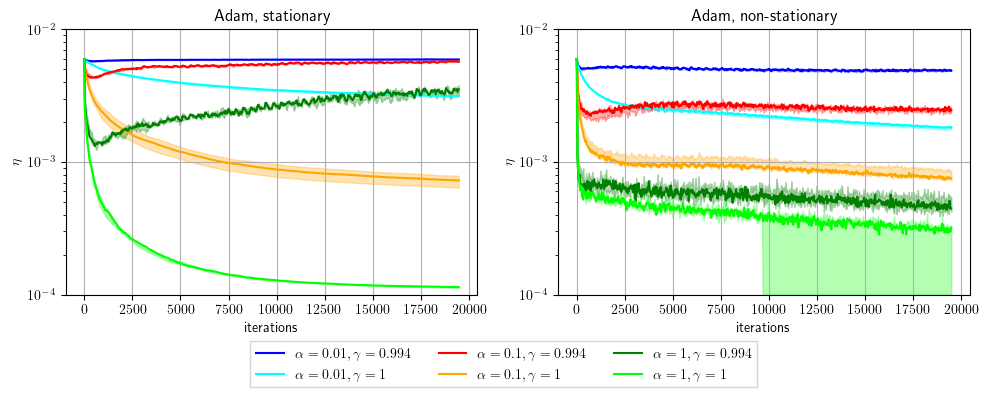

<Figure size 640x480 with 0 Axes>

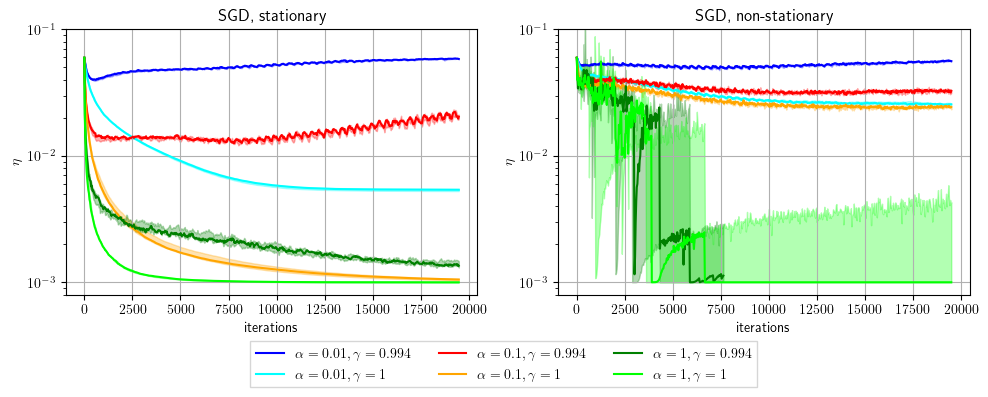

<Figure size 640x480 with 0 Axes>

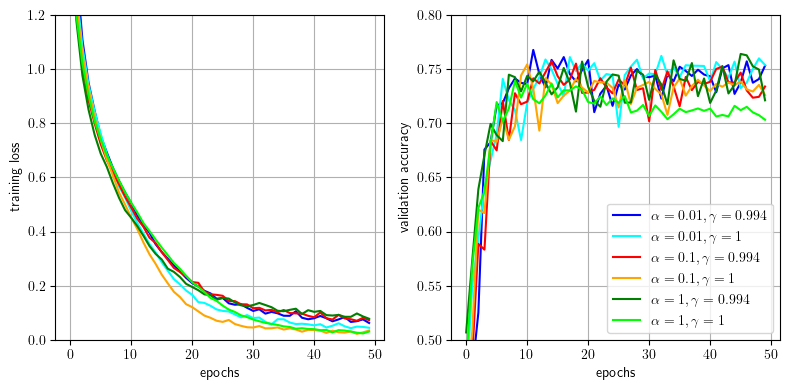

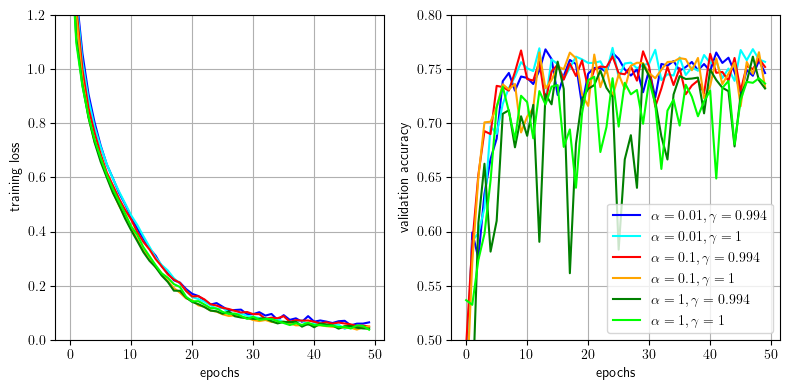

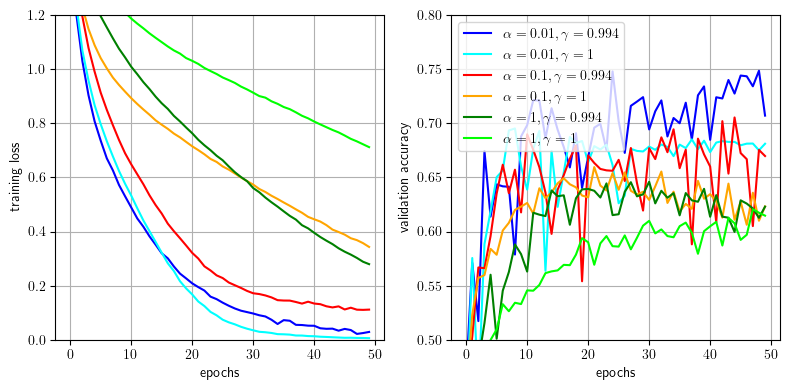

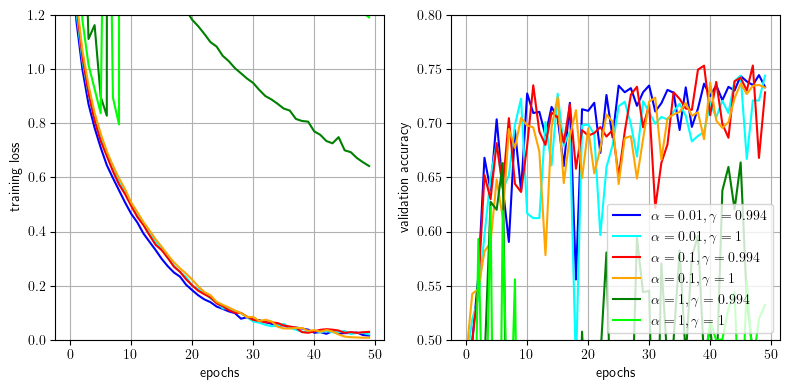

In [184]:
paths = [
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_1_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_0_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_1_1_0.001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_SGD_1_0_1_0.001_100",
    ]
]
label_updates = [
    'Adam, stationary',
    'Adam, non-stationary',
    'SGD, stationary',
    'SGD, non-stationary'
]
sources = [
    {"color": "blue", "label": "$\\alpha=0.01, \gamma=0.994$",},
    {"color": "cyan", "label": "$\\alpha=0.01, \gamma=1$"},
    {"color": "red", "label": "$\\alpha=0.1, \gamma=0.994$"},
    {"color": "orange", "label": "$\\alpha=0.1, \gamma=1$"},
    {"color": "green", "label": "$\\alpha=1, \gamma=0.994$"},
    {"color": "lime", "label": "$\\alpha=1, \gamma=1$"},
]
ylims = [
    (1e-4, 1e-2),
    (1e-4, 1e-2),
    (8e-4, 1e-1),
    (8e-4, 1e-1),
]
ylims_loss = [
    [(0.0, 1.2), (0.5, 0.8)]
]*4
def draw_group_of_lr_plots(paths, label_updates, sources, ylims, append_to_name=None):
    for i, (path_group, label_update, ylim) in enumerate(zip(paths, label_updates, ylims)):
        if i%2 == 0:
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        config = []
        for path, source in zip(path_group, sources):
            config.append({
                'path': path,
                **source
            })
#             config[-1]['label'] = label_update + ' ' + config[-1]['label']
        name = label_update.replace(',', '_').replace(' ', '').replace('-', '_').lower()
        if append_to_name is not None:
            name += append_to_name
        handles = draw_lr_plot(config, '', ax=axs[i%2], save=False, sample=30)
        axs[i%2].set_ylim(ylim)
        axs[i%2].set_title(label_update)
        if i%2 == 1:
            plt.legend()
            plt.tight_layout()
            fig.subplots_adjust(bottom=0.25)
            axs[-1].legend(handles = handles, labels=[c['label'] for c in config], loc='upper right', 
             bbox_to_anchor=(0.5, -0.15),fancybox=False, shadow=False, ncol=3)
            plt.savefig(f'paper/figures/experts/lognormal_{name}.pdf')
            plt.show()
            plt.clf()
            
def draw_group_of_loss_plots(paths, label_updates, sources, ylims, append_to_name=None):
    for i, (path_group, label_update, ylim) in enumerate(zip(paths, label_updates, ylims)):
        config = []
        for path, source in zip(path_group, sources):
            config.append({
                'path': path,
                'start': 0,
                'end': 1,
                **source
            })
        name = label_update.replace(',', '_').replace(' ', '').replace('-', '_').lower()
        if append_to_name is not None:
            name += append_to_name
        draw_loss_acc_plot(config, name, ylim_loss=(0.0, 1.2) if ylim is None else ylim[0],
                           ylim_acc=(0.65, 0.88) if ylim is None else ylim[1])

draw_group_of_lr_plots(paths, label_updates, sources, ylims)
draw_group_of_loss_plots(paths, label_updates, sources, ylims = ylims_loss)

In [146]:
sources = [
    [
        "SmallResnet20_CIFAR10_augment_Adam_0.1",
        "SmallResnet20_CIFAR10_augment_Adam_0.001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_1_0.1_0.0001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_Adam_1_1_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_Adam_0.1",
        "SmallResnet20_CIFAR10_augment_Adam_0.001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_Adam_1_0_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_SGD_0.1",
        "SmallResnet20_CIFAR10_augment_SGD_0.001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_1_1_0.001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_SGD_1_1_1_0.001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_SGD_0.1",
        "SmallResnet20_CIFAR10_augment_SGD_0.001",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_0_1_0.001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_0_1_0.001_normalize_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_SGD_1_0_1_0.001_100",
    ],
]


rows = [
    'Const $\eta=10^{-1}$',
    'Const $\eta=10^{-3}$',
    'Lognorm, $\\alpha=0.01$',
    'Lognorm, $\\alpha=0.1$',
    'Lognorm, $\\alpha=0.01$, n',
    'Lognorm, $\\alpha=0.1$, n',
    'Exp $\\alpha=0.01$',
    'Exp $\\alpha=0.1$',
    'Logunif $\\alpha=0.01$',
    'Logunif $\\alpha=0.1$',
]
columns = [
    'Adam, stat',
    'Adam, non-stat',
    'SGD, stat',
    'SGD, non-stat',
]
get_stats(sources, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))

10it [00:00, 15.19it/s]
10it [00:00, 15.80it/s]
10it [00:00, 16.40it/s]
10it [00:00, 16.61it/s]

\begin{tabular}{lllll}
\toprule
{} &              Adam, stat &          Adam, non-stat &               SGD, stat &           SGD, non-stat \\
\midrule
Const $\eta=10^{-1}$      &       $0.611 \pm 0.053$ &       $0.611 \pm 0.053$ &  $\bm{0.764 \pm 0.007}$ &  $\bm{0.764 \pm 0.007}$ \\
Const $\eta=10^{-3}$      &       $0.762 \pm 0.003$ &       $0.762 \pm 0.003$ &       $0.608 \pm 0.015$ &       $0.608 \pm 0.015$ \\
Lognorm, $\alpha=0.01$    &       $0.760 \pm 0.007$ &  $\bm{0.768 \pm 0.013}$ &       $0.748 \pm 0.011$ &       $0.747 \pm 0.003$ \\
Lognorm, $\alpha=0.1$     &       $0.760 \pm 0.003$ &       $0.767 \pm 0.008$ &       $0.705 \pm 0.009$ &       $0.753 \pm 0.020$ \\
Lognorm, $\alpha=0.01$, n &       $0.604 \pm 0.013$ &       $0.624 \pm 0.029$ &       $0.675 \pm 0.010$ &       $0.696 \pm 0.002$ \\
Lognorm, $\alpha=0.1$, n  &       $0.596 \pm 0.011$ &       $0.672 \pm 0.018$ &       $0.658 \pm 0.012$ &       $0.713 \pm 0.007$ \\
Exp $\alpha=0.01$         &  $\bm{0.767 \pm 0.006}$

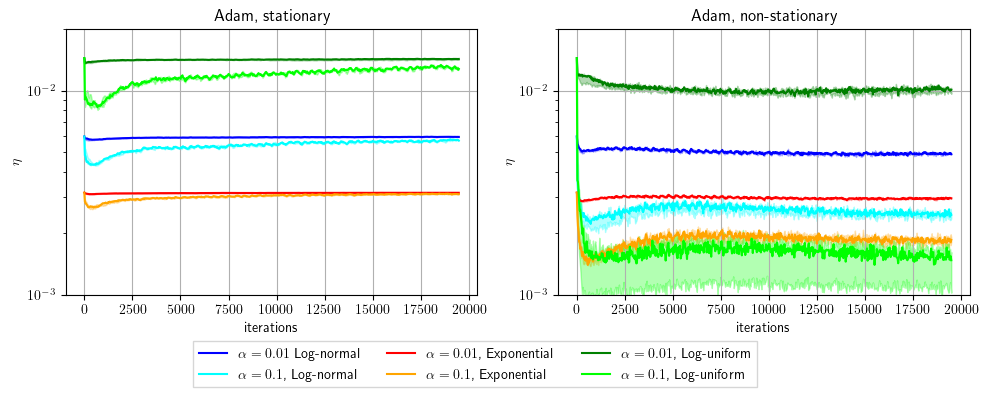

<Figure size 640x480 with 0 Axes>

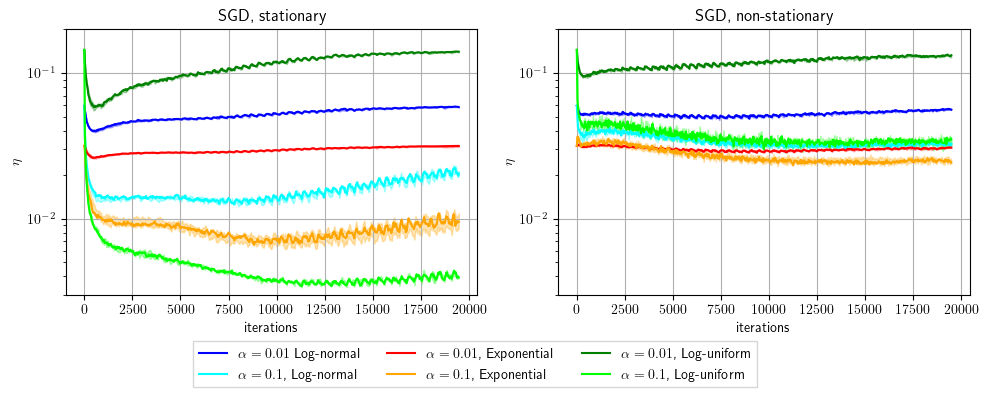

<Figure size 640x480 with 0 Axes>

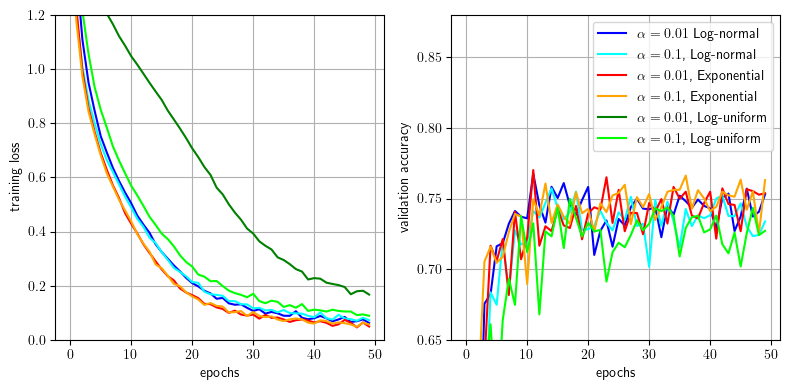

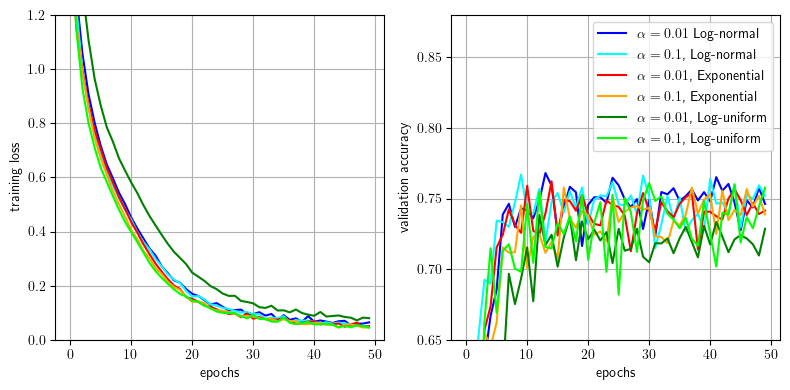

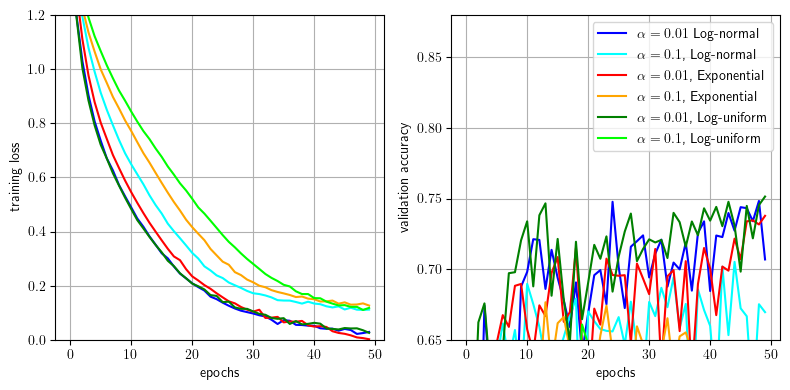

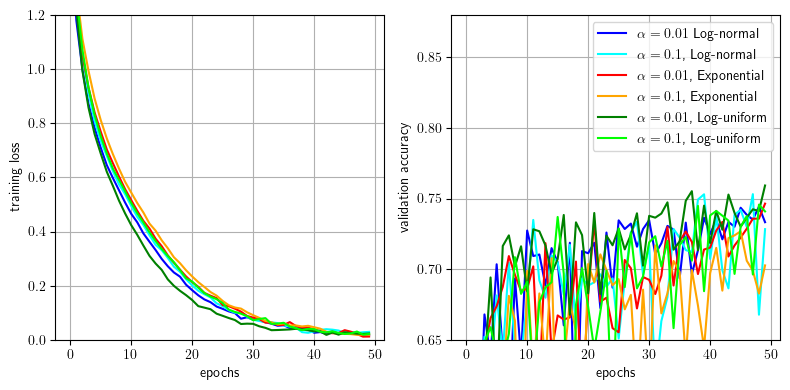

In [123]:
paths = [
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_Adam_1_1_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_Adam_1_1_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_Adam_1_0_0.1_0.0001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_Adam_1_0_0.1_0.0001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_1_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_SGD_1_1_1_0.001_100",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_exponential_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_0_1_0.001_100",
        "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_loguniform_SGD_1_0_1_0.001_100",
    ],
]

label_updates = [
    'Adam, stationary',
    'Adam, non-stationary',
    'SGD, stationary',
    'SGD, non-stationary'
]
sources = [
    {"color": "blue", "label": "$\\alpha=0.01$ Log-normal",},
    {"color": "cyan", "label": "$\\alpha=0.1$, Log-normal"},
    {"color": "red", "label": "$\\alpha=0.01$, Exponential"},
    {"color": "orange", "label": "$\\alpha=0.1$, Exponential"},
    {"color": "green", "label": "$\\alpha=0.01$, Log-uniform"},
    {"color": "lime", "label": "$\\alpha=0.1$, Log-uniform"},
]
ylims = [
    (1e-3, 2e-2),
    (1e-3, 2e-2),
    (3e-3, 2e-1),
    (3e-3, 2e-1),
]
draw_group_of_lr_plots(paths, label_updates, sources, ylims, append_to_name='dist')
draw_group_of_loss_plots(paths, label_updates, sources)

### Normalization

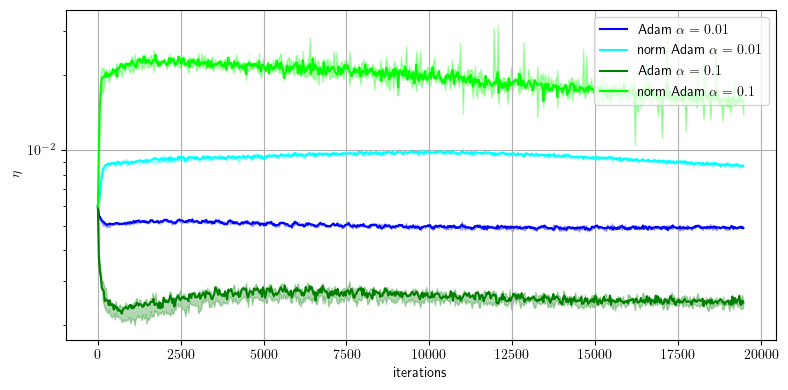

<Figure size 640x480 with 0 Axes>

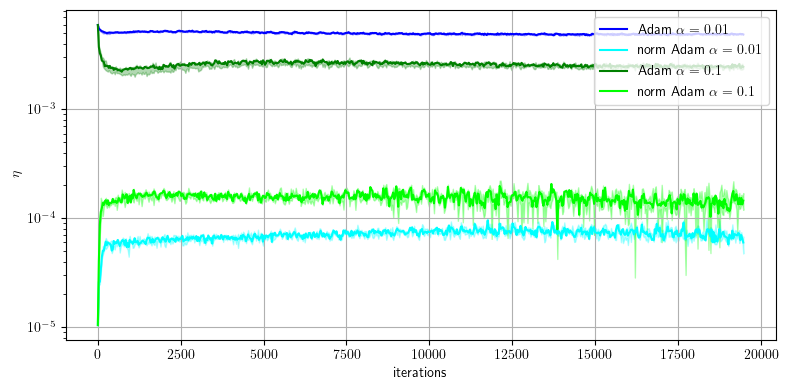

<Figure size 640x480 with 0 Axes>

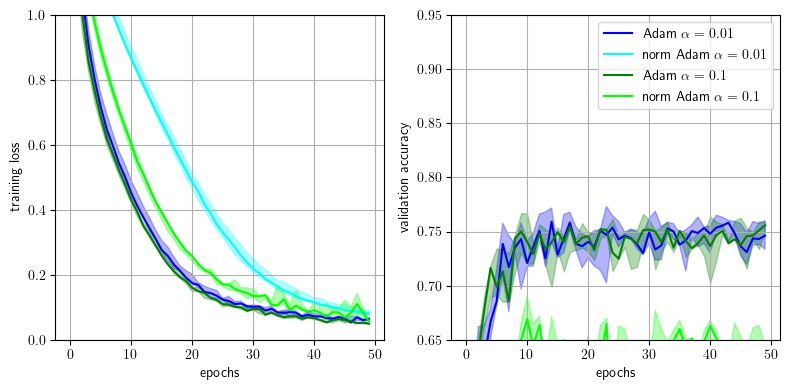

In [12]:
def unnormalize_lr(obj):
    if 'direction_length/train' in obj and len(obj['direction_length/train']) > 0:
        return np.array(obj['lr/train']) / np.array(obj['direction_length/train'])
    else:
        return np.array(obj['lr/train'])

sources = [
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100", "color": "blue", "label": "Adam $\\alpha=0.01$",},
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_normalize_100", "color": "cyan", "label": "norm Adam $\\alpha=0.01$"},
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100", "color": "green", "label": "Adam $\\alpha=0.1$",},
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_normalize_100", "color": "lime", "label": "norm Adam $\\alpha=0.1$"},
]
draw_lr_plot(sources, 'experts_normalized_compare', legend_loc='upper right', sample=30)
draw_lr_plot(sources, 'experts_normalized_compare_real', extraction_function=unnormalize_lr, legend_loc='upper right', sample=30)
draw_loss_acc_plot(sources, 'experts_normalized_compare')


<Figure size 640x480 with 0 Axes>

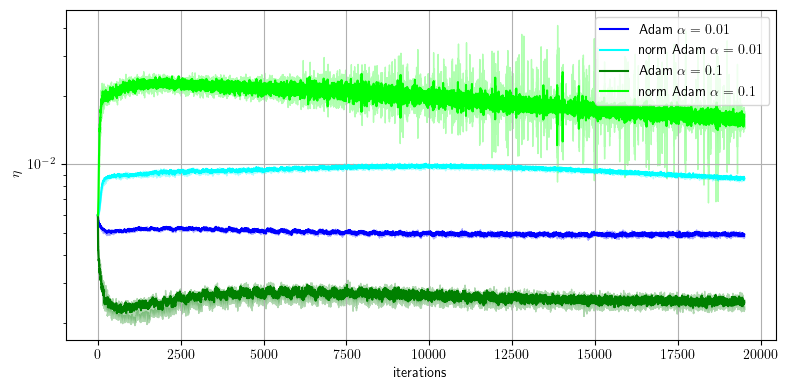

In [46]:
sources = [
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100", "color": "blue", "label": "Adam $\\alpha=0.01$",},
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_normalize_100", "color": "cyan", "label": "norm Adam $\\alpha=0.01$"},
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_100", "color": "green", "label": "Adam $\\alpha=0.1$",},
    {"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_0.1_0.0001_normalize_100", "color": "lime", "label": "norm Adam $\\alpha=0.1$"},
]
draw_lr_plot(sources, 'experts_normalized_compare', legend_loc='upper right')#, extraction_function=unnormalize_lr)

In [43]:
from scipy import stats
num_experts = 100
lr_min = 1e-4
lr_max = 1e-1
learning_rates = np.exp(
    np.linspace(np.log(lr_min), np.log(lr_max), num_experts)
)
x = np.linspace(-3, 3, num_experts)
probabilities = stats.norm.pdf(x)
probabilities /= np.sum(probabilities)
np.sum(probabilities*learning_rates)

0.005964904117544449

In [147]:
sources = [
    [
        "ResNet34_CIFAR10_augment_Adam_1",
        "ResNet34_CIFAR10_augment_Adam_0.1",
        "ResNet34_CIFAR10_augment_Adam_0.01",
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.0001",
        "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100",
    ],
    [
        "ResNet34_CIFAR10_augment_Adam_1",
        "ResNet34_CIFAR10_augment_Adam_0.1",
        "ResNet34_CIFAR10_augment_Adam_0.01",
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.0001",
        "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100",
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_1",
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.01",
        "ResNet34_CIFAR10_augment_SGD_0.001",
        "ResNet34_CIFAR10_augment_SGD_0.0001",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_1_1_0.001_100",
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_1",
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.01",
        "ResNet34_CIFAR10_augment_SGD_0.001",
        "ResNet34_CIFAR10_augment_SGD_0.0001",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_0_1_0.001_100",  
    ]
]
rows = [
    'Const. $\eta = 1$',
    'Const. $\eta = 10^{-1}$',
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'OneCycle $\eta_1$',
    'ExpertsLinearized',
]
columns = [
    'Adam, stat',
    'Adam, non-stat',
    'SGD, stat',
    'SGD, non-stat',
]
get_stats(sources, rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))

7it [00:00, 10.15it/s]
7it [00:00, 32.82it/s]
7it [00:00, 33.99it/s]
7it [00:00, 50.14it/s]

\begin{tabular}{lllll}
\toprule
{} &              Adam, stat &          Adam, non-stat &     SGD, stat & SGD, non-stat \\
\midrule
Const. $\eta = 1$       &                     $-$ &                     $-$ &       $0.864$ &       $0.864$ \\
Const. $\eta = 10^{-1}$ &                     $-$ &                     $-$ &       $0.909$ &       $0.909$ \\
Const. $\eta = 10^{-2}$ &       $0.909 \pm 0.002$ &       $0.909 \pm 0.002$ &       $0.889$ &       $0.889$ \\
Const. $\eta = 10^{-3}$ &       $0.920 \pm 0.002$ &       $0.920 \pm 0.002$ &           $-$ &           $-$ \\
Const. $\eta = 10^{-4}$ &       $0.909 \pm 0.004$ &       $0.909 \pm 0.004$ &           $-$ &           $-$ \\
OneCycle $\eta_1$       &  $\bm{0.934 \pm 0.001}$ &  $\bm{0.934 \pm 0.001}$ &  $\bm{0.923}$ &  $\bm{0.923}$ \\
ExpertsLinearized       &                 $0.916$ &                 $0.918$ &       $0.906$ &       $0.910$ \\
\bottomrule
\end{tabular}



<Figure size 640x480 with 0 Axes>

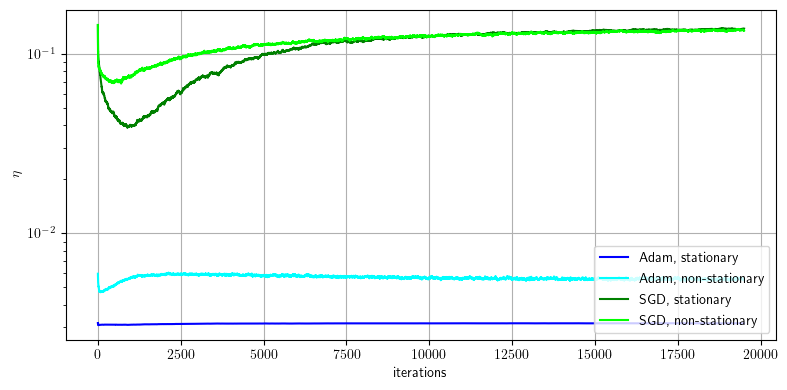

In [92]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100", "color": "blue", "label": "Adam, stationary"},
    {"path": "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100", "color": "cyan", "label": 'Adam, non-stationary'},
    {"path": "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_1_1_0.001_100", "color": "green", "label": 'SGD, stationary'},
    {"path": "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_0_1_0.001_100", "color": "lime", "label": 'SGD, non-stationary'},
]
draw_lr_plot(sources, 'experts_linearized_resnet34', legend_loc='lower right')

### Ill conditioned

{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_0_10_0.1_100', 'color': array([0.6, 0.6, 1. ]), 'label': None}
{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_0_10_0.1_100', 'color': array([0.3, 0.3, 1. ]), 'label': None}
{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_0_10_0.1_100', 'color': array([0., 0., 1.]), 'label': 'Non-stationary, $\\gamma = 1$'}
{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_1_10_0.1_100', 'color': array([1. , 0.6, 0.6]), 'label': None}
{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_1_10_0.1_100', 'color': array([1. , 0.3, 0.3]), 'label': None}
{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_1_10_0.1_100', 'color': array([1., 0., 0.]), 'label': 'Stationary, $\\gamma = 1$'}
{'path': 'SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_10_0.1_100', 'color': array([0.6, 1. , 0.6]), 'label': None}
{'path': 'Small

<Figure size 640x480 with 0 Axes>

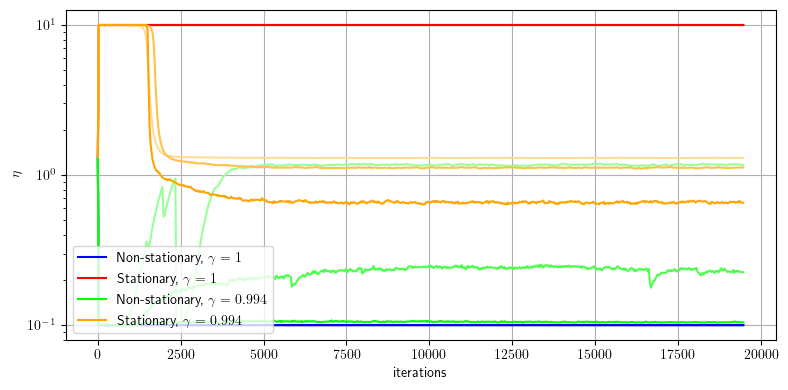

In [21]:
import matplotlib.colors as mcol

sources = [

{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_0_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_0_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_0_10_0.1_100", "color": "", "label": "Non-stationary, $\gamma = 1$",},

{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_1_Adam_1_1_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_1_Adam_1_1_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_1_Adam_1_1_10_0.1_100", "color": "", "label": "Stationary, $\gamma = 1$",},

{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_0_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_0_10_0.1_100", "color": "", "label": "Non-stationary, $\gamma = 0.994$",},    

{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_1_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_0.1_0.994_Adam_1_1_10_0.1_100", "color": "", "label": None,},
{"path": "SmallResnet20_CIFAR10_augment_ExpertsLinearized_1_0.994_Adam_1_1_10_0.1_100", "color": "", "label": "Stationary, $\gamma = 0.994$",},
]
colors = [
    'blue',
    'red',
    'lime',
    'orange',
]
colors_new = []
for color in colors:
    color = mcol.to_rgb(color)
    color = mcol.rgb_to_hsv(color)
    colors_new.append((color[0], color[1]*0.4, color[2]))
    colors_new.append((color[0], color[1]*0.7, color[2]))
    colors_new.append(color)
    
    
for source, color in zip(sources, colors_new):
    source['color'] = mcol.hsv_to_rgb(color)
    print(source)

draw_lr_plot(sources, 'ill', sample=30)

## Experts Nonlinearized

In [16]:
sources = [
    [
        "SmallResnet20_CIFAR10_augment_Adam_1",
        "SmallResnet20_CIFAR10_augment_Adam_0.1",
        "SmallResnet20_CIFAR10_augment_Adam_0.01",
        "SmallResnet20_CIFAR10_augment_Adam_0.001",
        "SmallResnet20_CIFAR10_augment_Adam_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_Adam_0.1,0.01,0.001,0.0001",
    ],
    [
        "SmallResnet20_CIFAR10_augment_Adam_1",
        "SmallResnet20_CIFAR10_augment_Adam_0.1",
        "SmallResnet20_CIFAR10_augment_Adam_0.01",
        "SmallResnet20_CIFAR10_augment_Adam_0.001",
        "SmallResnet20_CIFAR10_augment_Adam_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
    ],
    [
        "SmallResnet20_CIFAR10_augment_SGD_1",
        "SmallResnet20_CIFAR10_augment_SGD_0.1",
        "SmallResnet20_CIFAR10_augment_SGD_0.01",
        "SmallResnet20_CIFAR10_augment_SGD_0.001",
        "SmallResnet20_CIFAR10_augment_SGD_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_SGD_1_0.1,0.01,0.001,0.0001"
    ],
    [
        "SmallResnet20_CIFAR10_augment_SGD_1",
        "SmallResnet20_CIFAR10_augment_SGD_0.1",
        "SmallResnet20_CIFAR10_augment_SGD_0.01",
        "SmallResnet20_CIFAR10_augment_SGD_0.001",
        "SmallResnet20_CIFAR10_augment_SGD_0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
    ]
]

rows = [
    'Const $\eta=1$',
    'Const $\eta=10^{-1}$',
    'Const $\eta=10^{-2}$',
    'Const $\eta=10^{-3}$',
    'Const $\eta=10^{-4}$',
    '$\\alpha=0.01, \gamma=0.994$',
    '$\\alpha=0.01, \gamma=1$',
    '$\\alpha=0.1, \gamma=0.994$',
    '$\\alpha=0.1, \gamma=1$',
    '$\\alpha=1, \gamma=0.994$',
    '$\\alpha=1, \gamma=1$',
]
columns = [
    'Adam, 4 lrs',
    'Adam, 6 lrs',
    'SGD, 4 lrs',
    'SGD, 6 lrs',
]
get_stats(sources, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))

11it [00:00, 12.77it/s]


Warning 2 results/SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_Adam_0.1,0.01,0.001,0.0001_2/stats.json


8it [00:00, 11.04it/s]

Warning 2 results/SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05_2/stats.json


11it [00:00, 12.39it/s]
11it [00:00, 15.05it/s]
11it [00:00, 13.55it/s]

\begin{tabular}{lllll}
\toprule
{} &        Adam, 4 lrs &             Adam, 6 lrs &         SGD, 4 lrs &         SGD, 6 lrs \\
\midrule
Const $\eta=1$              &  $0.100 \pm 0.001$ &       $0.100 \pm 0.001$ &  $0.100 \pm 0.000$ &  $0.100 \pm 0.000$ \\
Const $\eta=10^{-1}$        &  $0.611 \pm 0.053$ &       $0.611 \pm 0.053$ &  $0.764 \pm 0.007$ &  $0.764 \pm 0.007$ \\
Const $\eta=10^{-2}$        &  $0.751 \pm 0.011$ &       $0.751 \pm 0.011$ &  $0.691 \pm 0.006$ &  $0.691 \pm 0.006$ \\
Const $\eta=10^{-3}$        &  $0.762 \pm 0.003$ &  $\bm{0.762 \pm 0.003}$ &  $0.608 \pm 0.015$ &  $0.608 \pm 0.015$ \\
Const $\eta=10^{-4}$        &  $0.645 \pm 0.024$ &       $0.645 \pm 0.024$ &  $0.392 \pm 0.002$ &  $0.392 \pm 0.002$ \\
$\alpha=0.01, \gamma=0.994$ &            $0.783$ &                 $0.744$ &       $\bm{0.793}$ &       $\bm{0.774}$ \\
$\alpha=0.01, \gamma=1$     &            $0.823$ &                 $0.606$ &            $0.649$ &            $0.631$ \\
$\alpha=0.1, \gamma=0.99

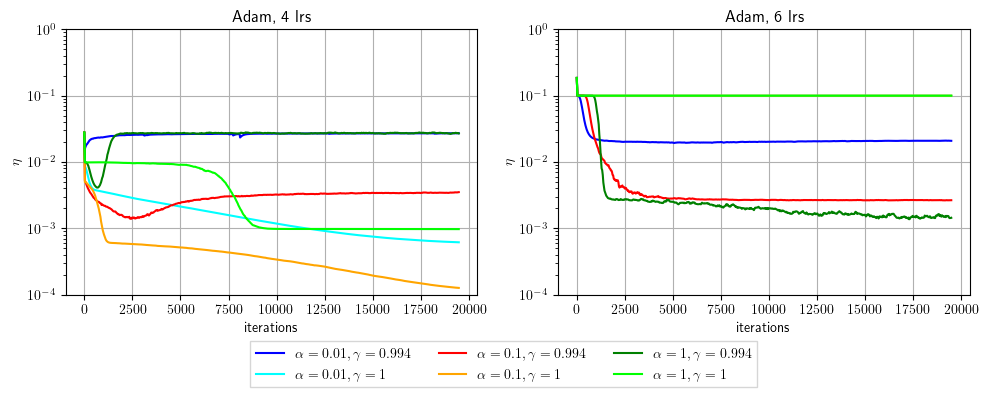

<Figure size 640x480 with 0 Axes>

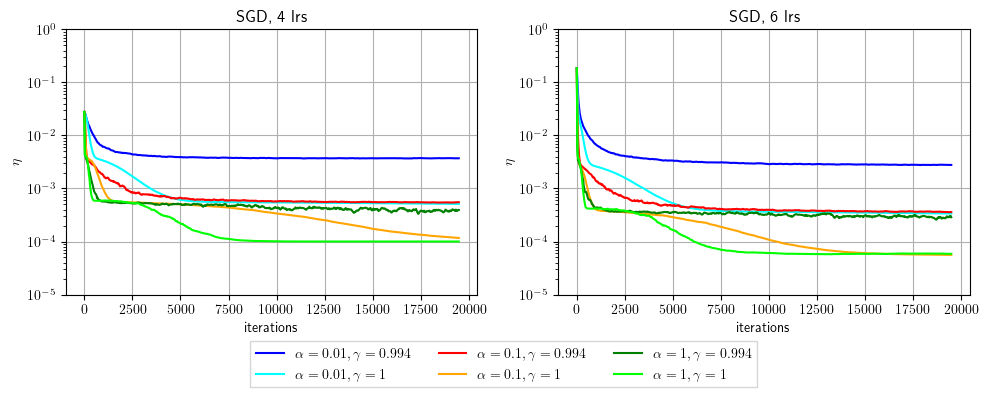

<Figure size 640x480 with 0 Axes>

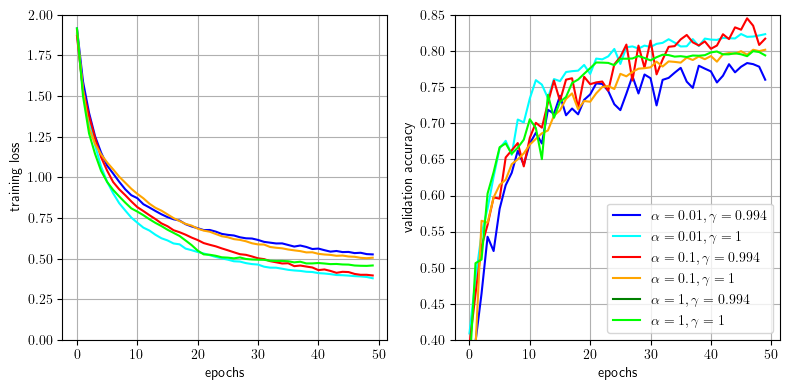

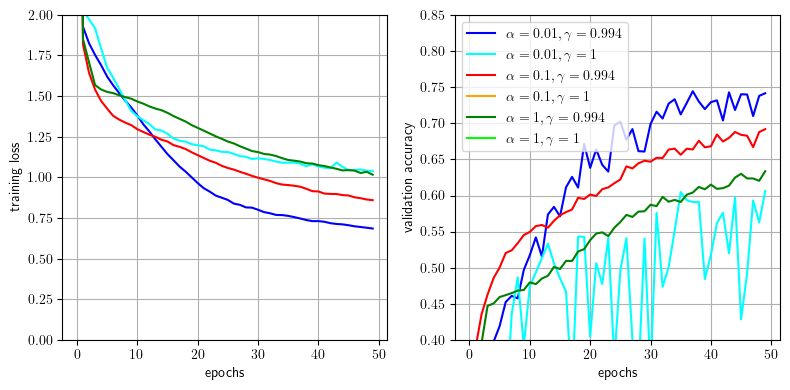

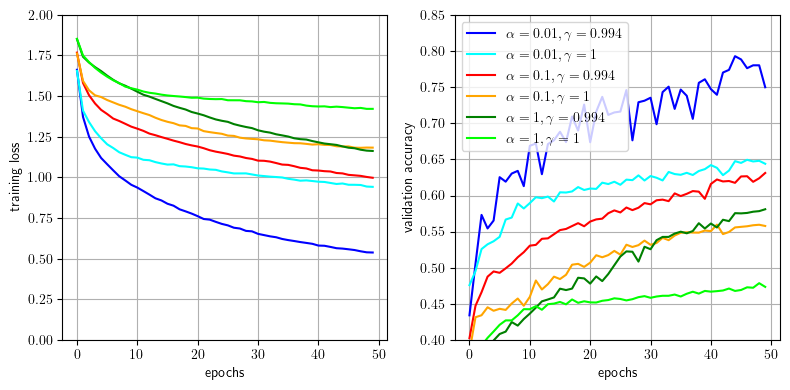

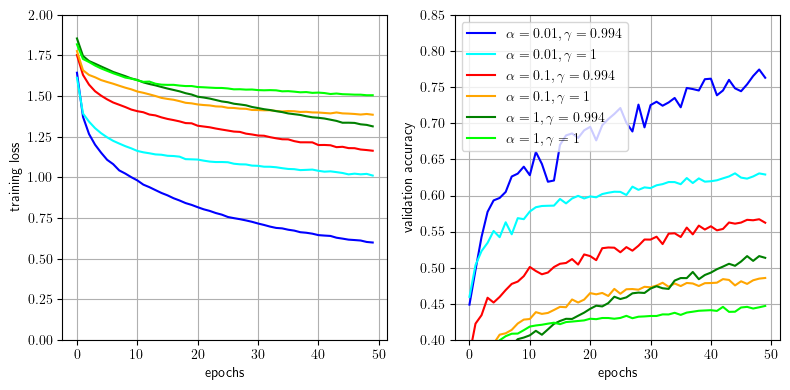

In [176]:
paths = [
    [
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_Adam_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_Adam_0.1,0.01,0.001,0.0001",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_SGD_1_0.1,0.01,0.001,0.0001"
    ],
    [
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_1_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_1_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "SmallResnet20_CIFAR10_augment_ExpertsNonLinearizedStationary_1_1_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
    ]
]

label_updates = [
    'Adam, 4 lrs',
    'Adam, 6 lrs',
    'SGD, 4 lrs',
    'SGD, 6 lrs'
]
sources = [
    {"color": "blue", "label": "$\\alpha=0.01, \gamma=0.994$",},
    {"color": "cyan", "label": "$\\alpha=0.01, \gamma=1$"},
    {"color": "red", "label": "$\\alpha=0.1, \gamma=0.994$"},
    {"color": "orange", "label": "$\\alpha=0.1, \gamma=1$"},
    {"color": "green", "label": "$\\alpha=1, \gamma=0.994$"},
    {"color": "lime", "label": "$\\alpha=1, \gamma=1$"},
]
ylims = [
    (1e-4, 1e-0),
    (1e-4, 1e-0),
    (1e-5, 1e-0),
    (1e-5, 1e-0),
]

loss_acc_ylims = [
    [(0, 2), (0.4, 0.85)],
    [(0, 2), (0.4, 0.85)],
    [(0, 2), (0.4, 0.85)],
    [(0, 2), (0.4, 0.85)],
]

draw_group_of_lr_plots(paths, label_updates, sources, ylims, append_to_name='nonlinearized')
draw_group_of_loss_plots(paths, label_updates, sources, ylims=loss_acc_ylims)

In [47]:
sources = [
    [
        "ResNet34_CIFAR10_augment_Adam_1",
        "ResNet34_CIFAR10_augment_Adam_0.1",
        "ResNet34_CIFAR10_augment_Adam_0.01",
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.0001",
        "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001",
    ],
    [
        "ResNet34_CIFAR10_augment_Adam_1",
        "ResNet34_CIFAR10_augment_Adam_0.1",
        "ResNet34_CIFAR10_augment_Adam_0.01",
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_Adam_0.0001",
        "ResNet34_CIFAR10_augment_Adam_0.001_OneCycleLR_0.01_1_50",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_1",
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.01",
        "ResNet34_CIFAR10_augment_SGD_0.001",
        "ResNet34_CIFAR10_augment_SGD_0.0001",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_0.1,0.01,0.001,0.0001",
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_1",
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_SGD_0.01",
        "ResNet34_CIFAR10_augment_SGD_0.001",
        "ResNet34_CIFAR10_augment_SGD_0.0001",
        "ResNet34_CIFAR10_augment_SGD_0.1_OneCycleLR_False_1_1_50",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
    ]
]

rows = [
    'Const $\eta=1$',
    'Const $\eta=10^{-1}$',
    'Const $\eta=10^{-2}$',
    'Const $\eta=10^{-3}$',
    'Const $\eta=10^{-4}$',
    'OneCycle $\eta_1$',
    'Experts Non-linearized',
]
columns = [
    'Adam, 4 lrs',
    'Adam, 6 lrs',
    'SGD, 4 lrs',
    'SGD, 6 lrs',
]
get_stats(sources, rows=rows, columns=columns, extraction_function=lambda a: np.max(a['acc/val']))

7it [00:00, 28.79it/s]
7it [00:00, 29.87it/s]
7it [00:00, 64.60it/s]
7it [00:00, 58.43it/s]

\begin{tabular}{lllll}
\toprule
{} &             Adam, 4 lrs &             Adam, 6 lrs &    SGD, 4 lrs &    SGD, 6 lrs \\
\midrule
Const $\eta=1$         &                     $-$ &                     $-$ &       $0.864$ &       $0.864$ \\
Const $\eta=10^{-1}$   &                     $-$ &                     $-$ &       $0.909$ &       $0.909$ \\
Const $\eta=10^{-2}$   &       $0.909 \pm 0.002$ &       $0.909 \pm 0.002$ &       $0.889$ &       $0.889$ \\
Const $\eta=10^{-3}$   &       $0.920 \pm 0.002$ &       $0.920 \pm 0.002$ &           $-$ &           $-$ \\
Const $\eta=10^{-4}$   &       $0.909 \pm 0.004$ &       $0.909 \pm 0.004$ &           $-$ &           $-$ \\
OneCycle $\eta_1$      &  $\bm{0.934 \pm 0.001}$ &  $\bm{0.934 \pm 0.001}$ &  $\bm{0.923}$ &  $\bm{0.923}$ \\
Experts Non-linearized &                 $0.890$ &                 $0.904$ &       $0.854$ &       $0.820$ \\
\bottomrule
\end{tabular}



<Figure size 640x480 with 0 Axes>

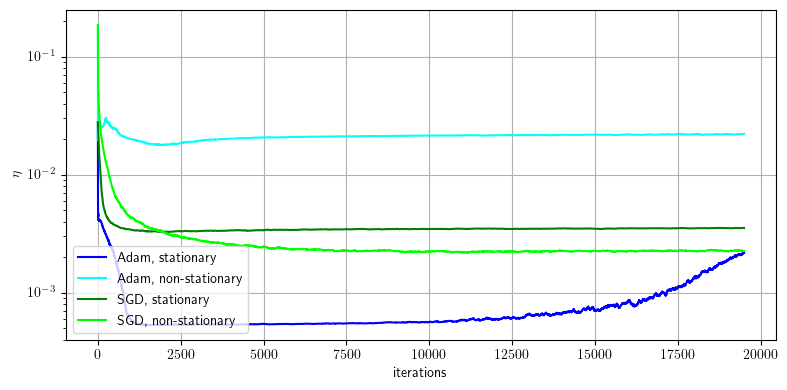

In [91]:
sources = [
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001", "color": "blue", "label": "Adam, stationary"},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05", "color": "cyan", "label": 'Adam, non-stationary'},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_0.1,0.01,0.001,0.0001", "color": "green", "label": 'SGD, stationary'},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05", "color": "lime", "label": 'SGD, non-stationary'},
]
draw_lr_plot(sources, 'experts_nonlinearized_resnet34')

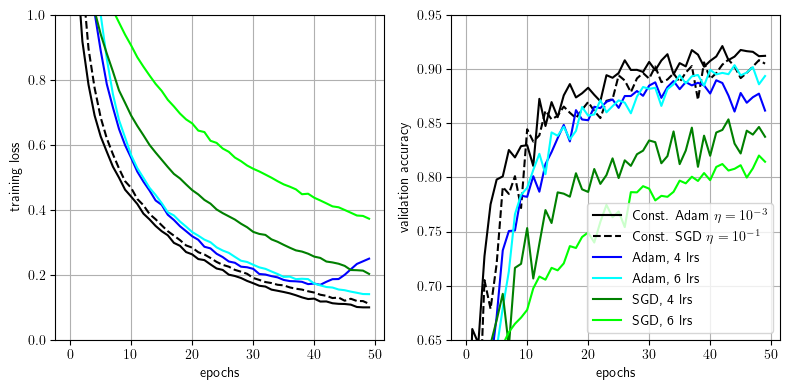

In [14]:
paths = [
    {"path": "ResNet34_CIFAR10_augment_Adam_0.001", "color": "black", "label": "Const. Adam $\\eta=10^{-3}$", "start": 0, "end": 1},
    {"path": "ResNet34_CIFAR10_augment_SGD_0.1", "color": "black", "linestyle": "dashed", "label": "Const. SGD $\\eta=10^{-1}$"},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001", "color": "blue", "label": "Adam, 4 lrs"},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05", "color": "cyan", "label": 'Adam, 6 lrs'},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_0.1,0.01,0.001,0.0001", "color": "green", "label": 'SGD, 4 lrs'},
    {"path": "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05", "color": "lime", "label": 'SGD, 6 lrs'},
]
draw_loss_acc_plot(paths, 'cifar10_nonlinearized')

In [16]:
sources_augment = [
    [
        "ResNet34_CIFAR100_augment_Adam_0.01_test",
        "ResNet34_CIFAR100_augment_Adam_0.001_test",
        "ResNet34_CIFAR100_augment_Adam_0.0001_test",
        "ResNet34_CIFAR100_augment_PalOptimizer",
        "ResNet34_CIFAR100_augment_Adam_0.001_OneCycleLR_0.01_1_200_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_increase_armijo_0.01_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_test",
        "ResNet34_CIFAR100_augment_ArmijoLineSearch_single_0.5_1.001_Adam_1_normalize_increase_armijo_0.01_test",
        "ResNet34_CIFAR100_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100",
        "ResNet34_CIFAR100_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100",
        "ResNet34_CIFAR100_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001",
        "ResNet34_CIFAR100_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
    ]
]
rows = [
    'Const. $\eta = 10^{-2}$',
    'Const. $\eta = 10^{-3}$',
    'Const. $\eta = 10^{-4}$',
    'Pal',
    'OneCycle $\eta_1$',
    'Armijo $ \\alpha = 0$',
    'Armijo $ \\alpha = 10^{-2}$',
    'norm Armijo $ \\alpha = 0$',
    'norm Armijo $ \\alpha = 10^{-2}$',
    'linearized experts, stationary',
    'linearized experts, non-stationary',
    'non-linearized experts, 4 lrs',
    'non-linearized experts, 6 lrs'
]
get_stats(sources_augment, rows=rows, columns=['Adam'])
get_stats(sources_augment, rows=rows, columns=['Adam'], extraction_function=lambda a: a['acc/train'][-1])
get_stats(sources_augment, rows=rows, columns=['Adam'], extraction_function=lambda a: a['acc/test'][-1])

13it [00:02,  5.38it/s]


\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$            &       $0.596$ \\
Const. $\eta = 10^{-3}$            &       $0.661$ \\
Const. $\eta = 10^{-4}$            &       $0.664$ \\
Pal                                &       $0.629$ \\
OneCycle $\eta_1$                  &       $0.701$ \\
Armijo $ \alpha = 0$               &       $0.702$ \\
Armijo $ \alpha = 10^{-2}$         &  $\bm{0.702}$ \\
norm Armijo $ \alpha = 0$          &       $0.700$ \\
norm Armijo $ \alpha = 10^{-2}$    &       $0.697$ \\
linearized experts, stationary     &       $0.619$ \\
linearized experts, non-stationary &       $0.598$ \\
non-linearized experts, 4 lrs      &       $0.571$ \\
non-linearized experts, 6 lrs      &       $0.598$ \\
\bottomrule
\end{tabular}



13it [00:01, 12.94it/s]


\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$            &       $0.965$ \\
Const. $\eta = 10^{-3}$            &       $0.982$ \\
Const. $\eta = 10^{-4}$            &       $0.981$ \\
Pal                                &       $0.979$ \\
OneCycle $\eta_1$                  &  $\bm{0.998}$ \\
Armijo $ \alpha = 0$               &       $0.981$ \\
Armijo $ \alpha = 10^{-2}$         &       $0.993$ \\
norm Armijo $ \alpha = 0$          &       $0.982$ \\
norm Armijo $ \alpha = 10^{-2}$    &       $0.993$ \\
linearized experts, stationary     &       $0.980$ \\
linearized experts, non-stationary &       $0.977$ \\
non-linearized experts, 4 lrs      &       $0.914$ \\
non-linearized experts, 6 lrs      &       $0.937$ \\
\bottomrule
\end{tabular}



13it [00:00, 13.18it/s]

\begin{tabular}{ll}
\toprule
{} &          Adam \\
\midrule
Const. $\eta = 10^{-2}$            &       $0.596$ \\
Const. $\eta = 10^{-3}$            &       $0.663$ \\
Const. $\eta = 10^{-4}$            &       $0.659$ \\
Pal                                &       $0.630$ \\
OneCycle $\eta_1$                  &       $0.697$ \\
Armijo $ \alpha = 0$               &       $0.706$ \\
Armijo $ \alpha = 10^{-2}$         &  $\bm{0.707}$ \\
norm Armijo $ \alpha = 0$          &       $0.695$ \\
norm Armijo $ \alpha = 10^{-2}$    &       $0.695$ \\
linearized experts, stationary     &       $0.618$ \\
linearized experts, non-stationary &       $0.606$ \\
non-linearized experts, 4 lrs      &       $0.575$ \\
non-linearized experts, 6 lrs      &       $0.602$ \\
\bottomrule
\end{tabular}



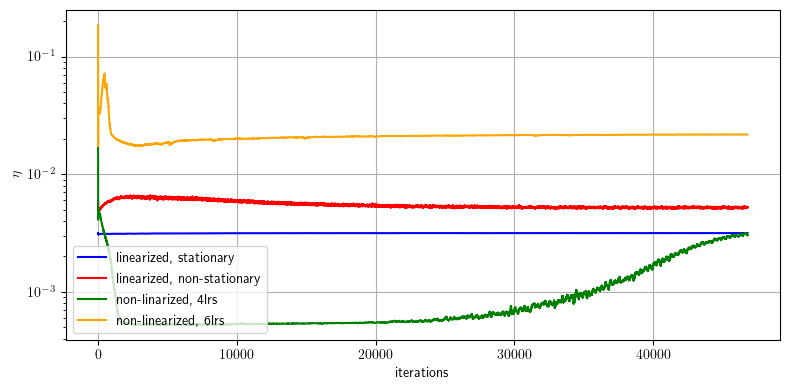

In [18]:
sources = [
    {"path": "ResNet34_CIFAR100_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100", "color": "blue", "label": "linearized, stationary"},
    {"path": "ResNet34_CIFAR100_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100", "color": "red", "label": 'linearized, non-stationary'},
    {"path": "ResNet34_CIFAR100_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001", "color": "green", "label": 'non-linarized, 4lrs'},
    {"path": "ResNet34_CIFAR100_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05", "color": "orange", "label": 'non-linearized, 6lrs'},
]
draw_lr_plot(sources, 'experts_cifar100')


In [24]:
sources = [
    [
        "ResNet34_CIFAR10_augment_Adam_0.001",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.1_0.994_Adam_0.1,0.01,0.001,0.0001",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_Adam_1,0.1,0.01,0.001,0.0001,1e-05",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_exponential_Adam_1_1_0.1_0.0001_100",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_Adam_1_0_0.1_0.0001_100"
    ],
    [
        "ResNet34_CIFAR10_augment_SGD_0.1",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_0.1,0.01,0.001,0.0001",
        "ResNet34_CIFAR10_augment_ExpertsNonLinearizedStationary_0.01_0.994_SGD_1_1,0.1,0.01,0.001,0.0001,1e-05",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_1_1_0.001_100",
        "ResNet34_CIFAR10_augment_ExpertsLinearized_0.01_0.994_loguniform_SGD_1_0_1_0.001_100",
    ]
]

columns = [
    "Adam",
    "SGD"
]

rows = [
    "const.",
    "non-linearized, 4 lrs",
    "non-linearized, 6 lrs",
    "linearized, stationary",
    "linearized, non-stationary"
]

get_stats(sources, columns=columns, rows=rows, file_extraction_function=read_times_from_tensorboard, precision=1)

5it [00:09,  1.99s/it]
5it [00:08,  1.62s/it]

\begin{tabular}{lll}
\toprule
{} &             Adam &           SGD \\
\midrule
const.                     &  $81.2 \pm 55.9$ &        $18.3$ \\
non-linearized, 4 lrs      &          $177.6$ &       $174.4$ \\
non-linearized, 6 lrs      &     $\bm{218.5}$ &  $\bm{217.8}$ \\
linearized, stationary     &           $93.0$ &        $90.1$ \\
linearized, non-stationary &           $94.0$ &        $90.8$ \\
\bottomrule
\end{tabular}

